### Rpy2 package

In [1]:
%load_ext rpy2.ipython

### Importing R packages

In [2]:
%R library(latentcor)
%R library(sn)

R[write to console]: Loading required package: stats4

R[write to console]: Package 'sn', 2.0.2 (2022-03-07). Type 'help(SN)' and 'help(overview-sn)' for basic information.
The package redefines function 'sd' but its usual working is unchanged.

R[write to console]: 
Attaching package: ‘sn’


R[write to console]: The following object is masked from ‘package:stats’:

    sd




'sn','stats4','latentcor',...,'datasets','methods','base'


### Importing Python libraries

In [3]:
import pandas as pd
import warnings
import numpy as np
import multiprocessing
import math
from timeit import default_timer as timer
from joblib import Parallel, delayed


#Number of cores
num_cores = multiprocessing.cpu_count()

jobs=num_cores-1


import matplotlib.pyplot as plt
%matplotlib inline

#knockpy
import knockpy
from knockpy.knockoff_filter import KnockoffFilter
from knockpy.knockoff_stats import data_dependent_threshhold

#GGlasso
from gglasso.problem import glasso_problem


In [4]:
#Import the package rpy2
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import r, pandas2ri
from rpy2.robjects.conversion import localconverter

# import R's packages
base = importr('base')
glmnet = importr('glmnet')
dplyr = importr('dplyr')
survival = importr('survival')

### Auxiliary functions

In [5]:
#Function to make selections
def make_selections(W, fdr):
    """" Calculate data dependent threshhold and selections """
    threshold = data_dependent_threshhold(W=W, fdr=fdr)
    selected_flags = (W >= threshold).astype("float32")
    return selected_flags


def glasso_function(x):
    
    #Instantiate the  glasso_problem
    x = np.array(x)
    P = glasso_problem(x, N=n, reg_params = {'lambda1': 0.05}, latent = False, do_scaling = False)

    # Next, do model selection by solving the problem on a range of lambda values.
    lambda1_range = np.logspace(1, -5, 30)
    modelselect_params = {'lambda1_range': lambda1_range}
    P.model_selection(modelselect_params = modelselect_params, method = 'eBIC', gamma = 0.1)

    #Precision and Sigma matrices
    sol = P.solution.precision_
    return np.linalg.inv(sol)   

def lasso_glmnet(x):
    
  #Transformation to a pandas data.frame
  x = pd.DataFrame(x)
  
  #Convertion of the pandas dataframe to a R dataframe  
  sim = x
  with localconverter(robjects.default_converter + pandas2ri.converter):
    r_sim = robjects.conversion.py2rpy(sim)
  robjects.globalenv["r_sim"] = r_sim
  
  #Loading R libraries  
  base = importr('base')
  glmnet = importr('glmnet')
  dplyr = importr('dplyr')
  survival = importr('survival')

  #Fitting the Cox’s proportional hazards model employing GLMNET
  robjects.r('''
        X <- r_sim %>% select(-c("Status", "Survival_time"))
        X_matrix <- as.matrix(X)
        y <- r_sim %>% select(c("Status", "Survival_time"))
        y_surv <- Surv(y$Survival_time,y$Status)
        cvfit <- cv.glmnet(X_matrix, y_surv, alpha=1, family = "cox", type.measure = "C", nfolds = 5, standardize = TRUE)
        fit <- glmnet(X_matrix,y_surv, alpha = 1, lambda =cvfit$lambda.min, family = "cox", standardize = TRUE)
        fit_coef <- coef(fit)
        fit_coef_vec <- as.vector(fit_coef)
        ''')
  #Coefficients of the best model 
  r_fit_coef_vec = robjects.globalenv['fit_coef_vec']  
  #Transformation to a numpy array
  fit_coef_vec = np.array(r_fit_coef_vec)
    
  return fit_coef_vec  


def latentcor_estimation(x, types):
    
  #Transformation to a pandas data.frame
  x = pd.DataFrame(x)
  
  #Convertion of the pandas dataframe to a R dataframe  
  sim = x
  with localconverter(robjects.default_converter + pandas2ri.converter):
    r_sim = robjects.conversion.py2rpy(sim)
  
  robjects.globalenv["r_sim"] = r_sim
  robjects.globalenv["types"] = types
  
  #Loading R libraries  
  base = importr('base')
  latentcor = importr('latentcor')
  dplyr = importr('dplyr')

  #Fitting the 
  robjects.r('''
        latentcor_hat_r <- latentcor(r_sim , types = types, method="original")$R  
        ''')
      
  #Matrix transformation to a numpy array
  latentcor_hat_r = robjects.globalenv['latentcor_hat_r']
  latentcor_hat = np.array(latentcor_hat_r)

  return latentcor_hat


### Simulation setup

In [6]:
t_initial = timer()

n = 300 #Number of observations
p = 300 #Number of variables

p_bin = 20 #Number of binary covariates

#Active covariates
p_nonnull_cont = 35
p_nonnull_ordinal = 5 

#Number of simulations
nsim = 50

n_cv = 5  #Cross validation
FDR = 0.2 #False discovery rate

#Survival Weibull distribution parameters (scale --> sigma, shape --> nu, lambda=1/(scale^shape))
lambda_T = 0.05 # lamnda=1/(scale^shape)=1/(sigma^nu)=1/(sigma^a)
nu_T = 1.5 # With nu_T=1(shape_T=1) we have the exponential distribution

#Beta coefficients
beta_coef_1 =  np.array([ 1,  1, -1, -1,  1,  1, -1,  1, -1, -1,  1, -1,  1, 
         1, -1,  -1,  1, -1, -1,  1, -1,  1, -1,   1, -1,  1,
       -1,  1, -1,  1, -1, -1,  1,  1,  1,  1, -1, -1,   1, -1])

beta_coef = beta_coef_1
#To change the coefficient's magnitud
beta_coef = np.where(beta_coef_1==1, 0.7, -0.7)

#Censored upper limit
#u_max=88

#Number of elements by block
b_by_block = 10 # 10 for size p=500 

#Correlation AR1(by blocks)
rho = 0.6

#Skew-t distribution
skew_dist = "Yes" # values ["Yes", "No"]
alpha_level = 2
#nu_level = 5

# Nu_level = 1

In [7]:
replication = 1000000

#To change the tailedness
nu_level = 4

#Because the varying feature changes the censoring level, 
#u_max needs to be adjusted to mantain the same censoring through all scenarios
u_max=64

### Correlation matrix

In [8]:
#From Pyhton to R
%R -i p
%R -i b_by_block
%R -i rho

%R n_blocks <- p%/%b_by_block
%R covMat <- diag(n_blocks) %x% matrix(rho^abs(matrix(1:b_by_block,b_by_block, b_by_block, byrow = TRUE) - matrix(1:b_by_block, b_by_block, b_by_block)), b_by_block, b_by_block)
%R diag(covMat) <- 1

#From R to Pyhton
%R -o covMat
 

In [9]:
#For the truncated ECFD estimator
delta_n = 1/( (4*n**(1/4))*math.sqrt(math.pi*math.log(n)) )

### Simulations: design matrix X and survival time t

In [10]:
if 'X' in globals():
    del X

In [11]:
#Arrays and lists to save information
ls_simulations = list(range(nsim))
ls_beta = list(range(nsim))
ls_X = list(range(nsim))
ls_types = list(range(nsim))
np_censoring = np.zeros(nsim)
np_mean_survival_time = np.zeros(nsim)

ti = timer() #Initial time


for i in range(nsim):
    
  #Set seed for replication
  np.random.seed(i+replication)  #Python
  %R -i i
  %R -i replication
  %R set.seed(i+replication)  #R

  #Sigma assignation
  Sigma = covMat

  #From Python to R 
  %R -i Sigma
  %R -i n
  %R -i p_bin
  %R -i p  
  %R -i p_nonnull_ordinal 
  %R -i p_nonnull_cont 
  %R -i alpha_level
  %R -i nu_level
  
  #Creation of the vector with correlation information
  %R lowerpart <- lower.tri(Sigma)
  %R rhos <- Sigma[lowerpart] 
  %R p_con <- p - p_bin


  #Binary and continiuos variables
  %R binary <- rep("bin", p_bin)
  %R con <- rep("con", p_con)
  %R types <- sample(c(binary, con))
  
  #Simulations of a mixed random vector
  %R X_norm_bin <- as.data.frame(gen_data(n = n, types = types, rhos = rhos, copulas="no", XP = NULL, showplot = FALSE)$X)
  %R X <- X_norm_bin

  if (skew_dist=="Yes"):  
    #There is seldom an error using the default solver "NB" for the function qsn().
    #Thus, in case of error, the solver is switched to "RFB"
    %R for(i in 1:p) {   if(types[i]=="con"){ tryCatch({X[,i] <-as.vector(qst(pnorm(X_norm_bin[,i], mean=0,sd=1),xi=0, omega=1,alpha=alpha_level,nu=nu_level))}, error=function(e){X[,i] <-as.vector(qst(pnorm(X_norm_bin[,i], mean=0,sd=1),xi=0, omega=1,alpha=alpha_level, nu=nu_level, solver="RFB"))}) }}
      
  #Creating a dataframe using the design matrix X
  #From R to Pyhton
  %R -o X 
  %R -o types
  %R -o p_con
  
  X.reset_index(drop=True, inplace=True)
  ls_X[i] = X
  ls_types[i] = types
  df_X = pd.DataFrame(X)

  #Names for the variables (X)
  numbers = np.arange(1,p+1)
  var_names = ['Var'+ str(number) for number in numbers]
  df_X.columns= var_names

  #Survival time simulation

  #Extracting the ordinal and continuous variables
  %R col_ind_ordinal <- sapply(X, function(col) length(unique(col)) < 4)
  %R col_ind_cont <- sapply(X, function(col) length(unique(col)) > 4)
  %R col_names <- names(X)
  %R col_names_ordinal <- col_names[col_ind_ordinal]
  %R col_names_cont <- col_names[col_ind_cont]  

  #Variables and coefficients nonnull
  if (p_nonnull_ordinal==0):
      %R col_nonnull <- c(sample(col_names_cont, size=p_nonnull_cont, replace=FALSE))
  else:
      #If there are ordinal nonnull variables the proportion of nonnull continuous and nonnull ordinal
      #remains the same between diferent simulated data sets  
      %R col_nonnull <- c(sample(col_names_cont, size=p_nonnull_cont, replace=FALSE), sample(col_names_ordinal, size=p_nonnull_ordinal, replace=FALSE))
  
  %R ind_betas <- as.numeric(substr(col_nonnull,start=2,stop=4))
  %R -o ind_betas 
  ind_betas_sort = np.sort(ind_betas.astype(int))
  
  #betas and magnitud
  beta = np.zeros(p,dtype=float)
  beta[ind_betas_sort-1] = beta_coef
  ls_beta[i] = beta

  #Survival time simulations (Bender et al. 2006)
  t = ( - (np.log(np.random.uniform(low=0.0, high=1.0, size=n)) )/( lambda_T*np.exp( np.dot(X, beta) ) ))**(1/nu_T)

  #Censored time and censored indicator
  t_cens = np.random.uniform(0, u_max, size=n) #With Upper=70 --> 34% of censoring
  I_cens = np.where(t<= t_cens, 1, 0)

  #Observed time 
  t_obs = np.minimum(t, t_cens)    

  #Creating the dataframe with survival information
  df_Y = pd.DataFrame({ 'Status':I_cens,'Survival_time':t_obs})
  
  #Data frame with simulated data (Y,X)
  ls_simulations[i] = pd.concat([df_Y,df_X], axis=1)

  #Saving information
  np_censoring[i] = np.around((1-ls_simulations[i]["Status"].sum()/n)*100,decimals=4)
  np_mean_survival_time[i] = ls_simulations[i]["Survival_time"].mean()
    
  #Eliminating X (If not, X causes problems in the loop why? I don´t know why)
  del X

time_simulations_1 = timer() - ti 

Censoring's level

In [12]:
np_censoring

array([30.3333, 33.6667, 22.3333, 22.6667, 33.6667, 35.3333, 16.6667,
       36.6667, 31.6667, 29.    , 25.6667, 30.3333, 25.6667, 35.    ,
       32.3333, 39.    , 32.    , 36.6667, 33.6667, 25.6667, 29.3333,
       29.3333, 24.3333, 28.    , 24.6667, 35.3333, 27.    , 25.3333,
       36.6667, 25.6667, 28.6667, 25.3333, 40.3333, 27.6667, 26.    ,
       34.6667, 24.3333, 25.3333, 32.3333, 26.6667, 25.6667, 27.    ,
       34.6667, 32.6667, 37.    , 28.6667, 26.    , 35.3333, 38.    ,
       29.3333])

In [13]:
np_censoring.mean()

29.98667

### Cox’s proportional hazards model  with lasso penalization (glmnet)

In [14]:
np_Number_CoxLasso_Rejections = np.zeros(nsim)
np_CoxLasso_Power = np.zeros(nsim)
np_CoxLasso_FDP = np.zeros(nsim)
np_CoxLasso_FD = np.zeros(nsim)

ti = timer() #Initial time

#Parallel code with Joblib
ls_coef_CoxLasso = Parallel(n_jobs=jobs)(delayed(lasso_glmnet)(x) for x in ls_simulations)

for i in range(nsim):
  fit_coef_vec = ls_coef_CoxLasso[i] 
  
  #Variable selection of the Penalized Cox proportional hazard model  
  np_Number_CoxLasso_Rejections[i] = np.sum(fit_coef_vec!= 0)
  print("Number of non-zero coefficients: {}".format(np_Number_CoxLasso_Rejections[i]))
  np_rejections_CoxLasso = np.where(fit_coef_vec!= 0,1,0)

  #Printing and saving the Power and FDP of the Penalized Cox proportional hazard model  
  np_CoxLasso_Power[i] = np.around(100*(np.dot(np_rejections_CoxLasso, ls_beta[i] != 0) / (ls_beta[i] != 0).sum()), decimals=2)
  np_CoxLasso_FDP[i] = np.around(100*np.dot(np_rejections_CoxLasso, ls_beta[i] == 0) / np_rejections_CoxLasso.sum(), decimals=2)
  np_CoxLasso_FD[i] = np.around(np.dot(np_rejections_CoxLasso, ls_beta[i] == 0))
  print(f"The Penalized Cox proportional hazards model has discovered {np_CoxLasso_Power[i]}% of the non-nulls with a FDP of {np_CoxLasso_FDP[i]}%")

time_CoxLASSO_1 = timer() - ti 

Number of non-zero coefficients: 88.0
The Penalized Cox proportional hazards model has discovered 100.0% of the non-nulls with a FDP of 54.55%
Number of non-zero coefficients: 134.0
The Penalized Cox proportional hazards model has discovered 100.0% of the non-nulls with a FDP of 70.15%
Number of non-zero coefficients: 136.0
The Penalized Cox proportional hazards model has discovered 100.0% of the non-nulls with a FDP of 70.59%
Number of non-zero coefficients: 98.0
The Penalized Cox proportional hazards model has discovered 97.5% of the non-nulls with a FDP of 60.2%
Number of non-zero coefficients: 127.0
The Penalized Cox proportional hazards model has discovered 100.0% of the non-nulls with a FDP of 68.5%
Number of non-zero coefficients: 114.0
The Penalized Cox proportional hazards model has discovered 100.0% of the non-nulls with a FDP of 64.91%
Number of non-zero coefficients: 119.0
The Penalized Cox proportional hazards model has discovered 100.0% of the non-nulls with a FDP of 66.3

### Estimation of the Latent correlation matrix 

In [15]:
#matrices_latentcor = list(range(nsim))
np_Frobenius_norm_latentcor = np.zeros(nsim)

ti = timer() #Initial time

#Parallel code with Joblib
matrices_latentcor = Parallel(n_jobs=jobs)(delayed(latentcor_estimation)(x,types) for x,types in zip(ls_X,ls_types))

for i in range(nsim):
    
  #Relative Frobenius norm
  np_Frobenius_norm_latentcor[i]= np.linalg.norm(matrices_latentcor[i] -covMat, 'fro')/np.linalg.norm(covMat, 'fro')

time_latentcor_1 = timer() - ti 

### Graphical lasso estimation

In [16]:
np_Frobenius_norm_Sigma_hat = np.zeros(nsim)

ti = timer() #Initial time

#Parallel code with Joblib
matrices_Sigma_hat = Parallel(n_jobs=jobs)(delayed(glasso_function)(x) for x in matrices_latentcor)

for i in range(nsim):
    
    #Relative Frobenius norm
    np_Frobenius_norm_Sigma_hat[i]= np.linalg.norm(matrices_Sigma_hat[i]-covMat, 'fro')/np.linalg.norm(covMat, 'fro')

    
time_GraphicalLASSO_1 = timer() - ti 

ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminate

ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminate

ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminate

ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminate

ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminate

ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminate

ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminate

ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminate

ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminate

### Knockoffs sampling

In [17]:
ls_simulations_Xk_hat = list(range(nsim))

ti = timer() # Initial time for the loop

for i in range(nsim):

  X = ls_X[i]
  df_X = ls_X[i] 
  types = ls_types[i]
  
  #From Python to R
  %R -i X 
  %R -i types
  %R -i delta_n
  
  #Transformation of the marginal distribution to normal distribution
  %R X_ecdf <- X  
  %R X_norm_hat <- X
  
  #Empirical cumulative distribution function
  %R for(i in 1:p) {   if(types[i]=="con"){ X_ecdf[,i] <- as.vector(ecdf(X[,i])(X[,i])) }}

  #For truncation:
  #Continuous variables
  %R for(i in 1:p) {   if(types[i]=="con"){ X_ecdf[,i][ X_ecdf[,i] < delta_n] <- delta_n }}
  %R for(i in 1:p) {   if(types[i]=="con"){ X_ecdf[,i][ X_ecdf[,i] > (1-delta_n)] <- 1-delta_n }}                                    
  %R for(i in 1:p) {   if(types[i]=="con"){ X_norm_hat[,i] <- as.vector(qnorm( X_ecdf[,i] ) )}}
  #Ordinal variables
  %R for(i in 1:p) {   if(types[i]=="bin"){ X_norm_hat[,i][X[,i]==0] = (-1)}}  

  #From R to Python
  %R -o X_norm_hat
    
  #Object for Gaussian knockoffs using the Sigma_hat and method mvr
  Gaussian_sampler_hat = knockpy.knockoffs.GaussianSampler(X_norm_hat.to_numpy(), mu=None,
                                                           Sigma=matrices_Sigma_hat[i],
                                                           method='mvr', verbose=False)
  Xk_norm_hat = Gaussian_sampler_hat.sample_knockoffs()  

  
  #Creating a dataframes from the knockoffs Xk_norm_hat
  df_Xk_norm_hat = pd.DataFrame(Xk_norm_hat)

  #From Python to R
  %R -i df_Xk_norm_hat
  
  #Transformation of Gaussian knockoffs to the original marginal distribution
  %R df_Xk_hat <- df_Xk_norm_hat
   
  %R for(i in 1:p) {   if(types[i]=="con"){ df_Xk_hat[,i] <- as.vector(quantile(X[,i], probs=pnorm(df_Xk_norm_hat[,i]), type=8)) }}
  %R for(i in 1:p) {   if(types[i]=="bin"){ df_Xk_hat[,i][df_Xk_norm_hat[,i]>=0]= 1}}
  %R for(i in 1:p) {   if(types[i]=="bin"){ df_Xk_hat[,i][df_Xk_norm_hat[,i]<0]= 0}}
  
  #From R to Python  
  %R -o df_Xk_hat
  df_Xk_hat.reset_index(drop=True, inplace=True)
    
  #Creating the names for the variables in X
  numbers = np.arange(1,p+1)
  kvar_names = ['KVar'+ str(number) for number in numbers]
  df_Xk_hat.columns= kvar_names     

  #Final dataset
  ls_simulations_Xk_hat[i] = pd.concat([ls_simulations[i], df_Xk_hat], axis=1)
  
time_knockoffs_1 = timer() - ti 

### Cox’s proportional hazards model  with lasso penalization for (X,Xk_hat) (glmnet) 

In [18]:
np_Number_CoxLasso_Rejections_knockoff_hat = np.zeros(nsim)

tii = timer()#Initial time

#Parallel code with Joblib
ls_coef_knockoff_hat = Parallel(n_jobs=jobs)(delayed(lasso_glmnet)(x) for x in ls_simulations_Xk_hat)

for i in range(nsim): 
    np_Number_CoxLasso_Rejections_knockoff_hat[i] = np.sum(ls_coef_knockoff_hat[i]!= 0)

time_CoxLASSO_X_Xk_1 = timer() - tii 

### Wj using the LASSO coeficient difference statistics and threshold rejection

In [19]:
np_Number_Rejections_knockoff_hat = np.zeros(nsim)
np_knockoff_hat_Power = np.zeros(nsim)
np_knockoff_hat_FDP = np.zeros(nsim)
np_knockoff_hat_FD = np.zeros(nsim)

for i in range(nsim): 
  
  #feature important asignation
  Z = ls_coef_knockoff_hat[i]

  #Wj statistic
  pair_W = np.abs(Z[0:p]) - np.abs(Z[p:])

  #Threshold selection and variable selection 
  threshold = data_dependent_threshhold(W=pair_W, fdr= FDR)
  print("Threshold for knockoffs ")
  print(threshold)
  rejections = make_selections(W=pair_W, fdr= FDR)

  #Printing and saving the Power and FDP of the knockoff procedure   
  np_Number_Rejections_knockoff_hat[i] = rejections.sum()
  print("Number of non-zero knockoff coefficients: {}".format(np_Number_Rejections_knockoff_hat[i]))
  np_knockoff_hat_Power[i] = np.around(100*(np.dot(rejections, ls_beta[i] != 0) / (ls_beta[i] != 0).sum()), decimals=2)
  np_knockoff_hat_FDP[i] = np.around(100*np.dot(rejections, ls_beta[i] == 0) / rejections.sum(), decimals=2)
  np_knockoff_hat_FD[i] = np.around(np.dot(rejections, ls_beta[i] == 0) )
  print(f"The knockoff filter has discovered {np_knockoff_hat_Power[i]}% of the non-nulls with a FDP of {np_knockoff_hat_FDP[i]}%")


Threshold for knockoffs 
0.11344180314282767
Number of non-zero knockoff coefficients: 45.0
The knockoff filter has discovered 100.0% of the non-nulls with a FDP of 11.11%
Threshold for knockoffs 
0.0530698877664656
Number of non-zero knockoff coefficients: 62.0
The knockoff filter has discovered 95.0% of the non-nulls with a FDP of 38.71%
Threshold for knockoffs 
0.030648715316965055
Number of non-zero knockoff coefficients: 53.0
The knockoff filter has discovered 90.0% of the non-nulls with a FDP of 32.08%
Threshold for knockoffs 
0.049272428629112845
Number of non-zero knockoff coefficients: 43.0
The knockoff filter has discovered 95.0% of the non-nulls with a FDP of 11.63%
Threshold for knockoffs 
0.153169603358191
Number of non-zero knockoff coefficients: 38.0
The knockoff filter has discovered 92.5% of the non-nulls with a FDP of 2.63%
Threshold for knockoffs 
0.049212536904455276
Number of non-zero knockoff coefficients: 54.0
The knockoff filter has discovered 97.5% of the non-n

In [20]:
# Array of varying feature
np_varying_feature = np.repeat([nu_level],repeats=nsim,axis=0)


#Dataframe with simulated data
df_simulations_results_1 = pd.DataFrame({'nu_level':np_varying_feature,
                                 'Censoring indicator':np_censoring,
                                 'Mean survival time':np_mean_survival_time,
                                 'Relative Frobenius norm latentcor':np_Frobenius_norm_latentcor,
                                 'Relative Frobenius norm Sigma hat':np_Frobenius_norm_Sigma_hat,
                     'Number_CoxLasso_Rejections':np_Number_CoxLasso_Rejections, 
                     'CoxLasso_Power(%)':np_CoxLasso_Power, 
                     'CoxLasso_FDP(%)':np_CoxLasso_FDP,
                     'CoxLasso_FD':np_CoxLasso_FD,
                     'Number_CoxLasso_Rejections_knockoff_hat':np_Number_CoxLasso_Rejections_knockoff_hat,
                     'Number_Rejections_knockoff_hat':np_Number_Rejections_knockoff_hat, 
                     'knockoff_hat_Power(%)':np_knockoff_hat_Power, 
                     'knockoff_hat_FDP(%)':np_knockoff_hat_FDP,
                     'knockoff_hat_FD':np_knockoff_hat_FD})

In [21]:
df_simulations_results_1

,nu_level,Censoring indicator,Mean survival time,Relative Frobenius norm latentcor,Relative Frobenius norm Sigma hat,Number_CoxLasso_Rejections,CoxLasso_Power(%),CoxLasso_FDP(%),CoxLasso_FD,Number_CoxLasso_Rejections_knockoff_hat,Number_Rejections_knockoff_hat,knockoff_hat_Power(%),knockoff_hat_FDP(%),knockoff_hat_FD
0,4,30.3333,11.307551,0.763793,0.337637,88.0,100.0,54.55,48.0,176.0,45.0,100.0,11.11,5.0
1,4,33.6667,13.330041,0.763315,0.340430,134.0,100.0,70.15,94.0,154.0,62.0,95.0,38.71,24.0
2,4,22.3333,9.029561,0.765825,0.336173,136.0,100.0,70.59,96.0,123.0,53.0,90.0,32.08,17.0
3,4,22.6667,9.613447,0.770591,0.335659,98.0,97.5,60.20,59.0,113.0,43.0,95.0,11.63,5.0
4,4,33.6667,12.662512,0.754970,0.333927,127.0,100.0,68.50,87.0,175.0,38.0,92.5,2.63,1.0
5,4,35.3333,12.395014,0.765805,0.341832,114.0,100.0,64.91,74.0,131.0,54.0,97.5,27.78,15.0
6,4,16.6667,7.542796,0.766069,0.331179,119.0,100.0,66.39,79.0,167.0,41.0,90.0,12.20,5.0
7,4,36.6667,12.641499,0.764234,0.341912,145.0,100.0,72.41,105.0,150.0,47.0,90.0,23.40,11.0
8,4,31.6667,10.889749,0.757826,0.341348,116.0,100.0,65.52,76.0,108.0,45.0,85.0,24.44,11.0
9,4,29.0000,11.592131,0.762772,0.338559,119.0,100.0,66.39,79.0,112.0,41.0,90.0,12.20,5.0


In [22]:
df_simulations_results_1.mean()

nu_level                                     4.000000
Censoring indicator                         29.986670
Mean survival time                          11.470351
Relative Frobenius norm latentcor            0.764339
Relative Frobenius norm Sigma hat            0.335298
Number_CoxLasso_Rejections                 112.240000
CoxLasso_Power(%)                           99.100000
CoxLasso_FDP(%)                             63.926400
CoxLasso_FD                                 72.600000
Number_CoxLasso_Rejections_knockoff_hat    144.980000
Number_Rejections_knockoff_hat              46.300000
knockoff_hat_Power(%)                       91.500000
knockoff_hat_FDP(%)                         19.829600
knockoff_hat_FD                              9.700000
dtype: float64

# Nu_level = 2

In [23]:
replication = 1001000

#To change the tailedness
nu_level = 5

#Because the varying feature changes the censoring level, 
#u_max needs to be adjusted to mantain the same censoring through all scenarios
u_max=60

### Correlation matrix

In [24]:
#From Pyhton to R
%R -i p
%R -i b_by_block
%R -i rho

%R n_blocks <- p%/%b_by_block
%R covMat <- diag(n_blocks) %x% matrix(rho^abs(matrix(1:b_by_block,b_by_block, b_by_block, byrow = TRUE) - matrix(1:b_by_block, b_by_block, b_by_block)), b_by_block, b_by_block)
%R diag(covMat) <- 1

#From R to Pyhton
%R -o covMat
 

In [25]:
#For the truncated ECFD estimator (Reference___)
delta_n = 1/( (4*n**(1/4))*math.sqrt(math.pi*math.log(n)) )

### Simulations: design matrix X and survival time t

In [26]:
if 'X' in globals():
    del X

In [27]:
#Arrays and lists to save information
ls_simulations = list(range(nsim))
ls_beta = list(range(nsim))
ls_X = list(range(nsim))
ls_types = list(range(nsim))
np_censoring = np.zeros(nsim)
np_mean_survival_time = np.zeros(nsim)

ti = timer() #Initial time

for i in range(nsim):
    
  #Set seed for replication of the results
  np.random.seed(i+replication)  #Python
  %R -i i
  %R -i replication
  %R set.seed(i+replication)  #R

  #Sigma assignation
  Sigma = covMat

  #From Python to R 
  %R -i Sigma
  %R -i n
  %R -i p_bin
  %R -i p  
  %R -i p_nonnull_ordinal 
  %R -i p_nonnull_cont 
  %R -i alpha_level
  %R -i nu_level


  #Creation of the vector with correlation information
  %R lowerpart <- lower.tri(Sigma)
  %R rhos <- Sigma[lowerpart] 
  %R p_con <- p - p_bin


  #Binary and continiuos variables
  %R binary <- rep("bin", p_bin)
  %R con <- rep("con", p_con)
  %R types <- sample(c(binary, con))
  
  #Simulations of a mixed random vector
  %R X_norm_bin <- as.data.frame(gen_data(n = n, types = types, rhos = rhos, copulas="no", XP = NULL, showplot = FALSE)$X)
  %R X <- X_norm_bin

  if (skew_dist=="Yes"):  
    #There is seldom an error using the default solver "NB" for the function qsn().
    #Thus, in case of error, the solver is switched to "RFB"
    %R for(i in 1:p) {   if(types[i]=="con"){ tryCatch({X[,i] <-as.vector(qst(pnorm(X_norm_bin[,i], mean=0,sd=1),xi=0, omega=1,alpha=alpha_level,nu=nu_level))}, error=function(e){X[,i] <-as.vector(qst(pnorm(X_norm_bin[,i], mean=0,sd=1),xi=0, omega=1,alpha=alpha_level, nu=nu_level, solver="RFB"))}) }}
      
  #Creating a dataframe using the design matrix X
  #From R to Pyhton
  %R -o X 
  %R -o types
  %R -o p_con
  
  X.reset_index(drop=True, inplace=True)
  ls_X[i] = X
  ls_types[i] = types
  df_X = pd.DataFrame(X)

  #Names for the variables (X)
  numbers = np.arange(1,p+1)
  var_names = ['Var'+ str(number) for number in numbers]
  df_X.columns= var_names

  #Survival time simulation

  #Extracting the ordinal and continuous variables
  %R col_ind_ordinal <- sapply(X, function(col) length(unique(col)) < 4)
  %R col_ind_cont <- sapply(X, function(col) length(unique(col)) > 4)
  %R col_names <- names(X)
  %R col_names_ordinal <- col_names[col_ind_ordinal]
  %R col_names_cont <- col_names[col_ind_cont]  

  #Variables and coefficients nonnull
  if (p_nonnull_ordinal==0):
      %R col_nonnull <- c(sample(col_names_cont, size=p_nonnull_cont, replace=FALSE))
  else:
      #If there are ordinal nonnull variables the proportion of nonnull continuous and nonnull ordinal
      #remains the same between diferent simulated data sets  
      %R col_nonnull <- c(sample(col_names_cont, size=p_nonnull_cont, replace=FALSE), sample(col_names_ordinal, size=p_nonnull_ordinal, replace=FALSE))
  
  %R ind_betas <- as.numeric(substr(col_nonnull,start=2,stop=4))
  %R -o ind_betas 
  ind_betas_sort = np.sort(ind_betas.astype(int))
  
  #betas and magnitud
  beta = np.zeros(p,dtype=float)
  beta[ind_betas_sort-1] = beta_coef
  ls_beta[i] = beta

  #Survival time simulations (Bender et al. 2006)
  t = ( - (np.log(np.random.uniform(low=0.0, high=1.0, size=n)) )/( lambda_T*np.exp( np.dot(X, beta) ) ))**(1/nu_T)

  #Censored time and Censored indicator
  t_cens = np.random.uniform(0, u_max, size=n) #With Upper=70 --> 34% of censoring
  I_cens = np.where(t<= t_cens, 1, 0)

  #Observed time 
  t_obs = np.minimum(t, t_cens)    

  #Creating the dataframe with survival information
  df_Y = pd.DataFrame({ 'Status':I_cens,'Survival_time':t_obs})
  
  #Data frame with simulated data (Y,X)
  ls_simulations[i] = pd.concat([df_Y,df_X], axis=1)

  #Saving information
  np_censoring[i] = np.around((1-ls_simulations[i]["Status"].sum()/n)*100,decimals=4)
  np_mean_survival_time[i] = ls_simulations[i]["Survival_time"].mean()
    
  #Eliminating X (If not, X causes problems in the loop why? I don´t Know)
  del X

time_simulations_2 = timer() - ti 

### Cox’s proportional hazards model with lasso penalization (glmnet)

In [28]:
np_Number_CoxLasso_Rejections = np.zeros(nsim)
np_CoxLasso_Power = np.zeros(nsim)
np_CoxLasso_FDP = np.zeros(nsim)
np_CoxLasso_FD = np.zeros(nsim)

ti = timer() #Initial time

#Parallel code with Joblib
ls_coef_CoxLasso = Parallel(n_jobs=jobs)(delayed(lasso_glmnet)(x) for x in ls_simulations)

for i in range(nsim):
  fit_coef_vec = ls_coef_CoxLasso[i] 
  
  #Variable selection of the Penalized Cox proportional hazard model  
  np_Number_CoxLasso_Rejections[i] = np.sum(fit_coef_vec!= 0)
  print("Number of non-zero coefficients: {}".format(np_Number_CoxLasso_Rejections[i]))
  np_rejections_CoxLasso = np.where(fit_coef_vec!= 0,1,0)

  #Printing and saving the Power and FDP of the Penalized Cox proportional hazard model  
  np_CoxLasso_Power[i] = np.around(100*(np.dot(np_rejections_CoxLasso, ls_beta[i] != 0) / (ls_beta[i] != 0).sum()), decimals=2)
  np_CoxLasso_FDP[i] = np.around(100*np.dot(np_rejections_CoxLasso, ls_beta[i] == 0) / np_rejections_CoxLasso.sum(), decimals=2)
  np_CoxLasso_FD[i] = np.around(np.dot(np_rejections_CoxLasso, ls_beta[i] == 0))
  print(f"The Penalized Cox proportional hazards model has discovered {np_CoxLasso_Power[i]}% of the non-nulls with a FDP of {np_CoxLasso_FDP[i]}%")

time_CoxLASSO_2 = timer() - ti 

Number of non-zero coefficients: 67.0
The Penalized Cox proportional hazards model has discovered 97.5% of the non-nulls with a FDP of 41.79%
Number of non-zero coefficients: 143.0
The Penalized Cox proportional hazards model has discovered 100.0% of the non-nulls with a FDP of 72.03%
Number of non-zero coefficients: 100.0
The Penalized Cox proportional hazards model has discovered 97.5% of the non-nulls with a FDP of 61.0%
Number of non-zero coefficients: 139.0
The Penalized Cox proportional hazards model has discovered 100.0% of the non-nulls with a FDP of 71.22%
Number of non-zero coefficients: 116.0
The Penalized Cox proportional hazards model has discovered 100.0% of the non-nulls with a FDP of 65.52%
Number of non-zero coefficients: 116.0
The Penalized Cox proportional hazards model has discovered 100.0% of the non-nulls with a FDP of 65.52%
Number of non-zero coefficients: 108.0
The Penalized Cox proportional hazards model has discovered 100.0% of the non-nulls with a FDP of 62.

### Estimation of the Latent correlation matrix 

In [29]:
#matrices_latentcor = list(range(nsim))
np_Frobenius_norm_latentcor = np.zeros(nsim)

ti = timer() #Initial time

#Parallel code with Joblib
matrices_latentcor = Parallel(n_jobs=jobs)(delayed(latentcor_estimation)(x,types) for x,types in zip(ls_X,ls_types))

for i in range(nsim):
    
  #Relative Frobenius norm
  np_Frobenius_norm_latentcor[i]= np.linalg.norm(matrices_latentcor[i] -covMat, 'fro')/np.linalg.norm(covMat, 'fro')

time_latentcor_2 = timer() - ti 

### Graphical lasso estimation

In [30]:
np_Frobenius_norm_Sigma_hat = np.zeros(nsim)

ti = timer() #Initial time

#Parallel code with Joblib
matrices_Sigma_hat = Parallel(n_jobs=jobs)(delayed(glasso_function)(x) for x in matrices_latentcor)

for i in range(nsim):
    
    #Relative Frobenius norm
    np_Frobenius_norm_Sigma_hat[i]= np.linalg.norm(matrices_Sigma_hat[i]-covMat, 'fro')/np.linalg.norm(covMat, 'fro')
    
time_GraphicalLASSO_2 = timer() - ti 

ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminate

ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminate

ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminate

ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 14 iterations with status: optimal.
ADMM terminate

ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminate

ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminate

ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminate

ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminate

ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminate

ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminate

### Knockoffs sampling

In [31]:
ls_simulations_Xk_hat = list(range(nsim))

ti = timer()#Initial time for the loop

for i in range(nsim):

  X = ls_X[i]
  df_X = ls_X[i] 
  types = ls_types[i]
  
  #From Python to R
  %R -i X 
  %R -i types
  %R -i delta_n
  
  #Transformation of the marginal distribution to normal distribution
  %R X_ecdf <- X  
  %R X_norm_hat <- X
  
  #Empirical cumulative distribution function
  %R for(i in 1:p) {   if(types[i]=="con"){ X_ecdf[,i] <- as.vector(ecdf(X[,i])(X[,i])) }}

  #For truncation:
  #Continuous variables
  %R for(i in 1:p) {   if(types[i]=="con"){ X_ecdf[,i][ X_ecdf[,i] < delta_n] <- delta_n }}
  %R for(i in 1:p) {   if(types[i]=="con"){ X_ecdf[,i][ X_ecdf[,i] > (1-delta_n)] <- 1-delta_n }}                                    
  %R for(i in 1:p) {   if(types[i]=="con"){ X_norm_hat[,i] <- as.vector(qnorm( X_ecdf[,i] ) )}}
  #Ordinal variables
  %R for(i in 1:p) {   if(types[i]=="bin"){ X_norm_hat[,i][X[,i]==0] = (-1)}}  

  #From R to Python
  %R -o X_norm_hat
    
  #Object for Gaussian knockoffs using the Sigma_hat and method mvr
  Gaussian_sampler_hat = knockpy.knockoffs.GaussianSampler(X_norm_hat.to_numpy(), mu=None,
                                                           Sigma=matrices_Sigma_hat[i],
                                                           method='mvr', verbose=False)
  Xk_norm_hat = Gaussian_sampler_hat.sample_knockoffs()  

  
  #Creating a dataframes from the knockoffs Xk_norm_hat
  df_Xk_norm_hat = pd.DataFrame(Xk_norm_hat)

  #From Python to R
  %R -i df_Xk_norm_hat
   
  #Transformation of Gaussian knockoffs to the original marginal distribution
  %R df_Xk_hat <- df_Xk_norm_hat
   
  %R for(i in 1:p) {   if(types[i]=="con"){ df_Xk_hat[,i] <- as.vector(quantile(X[,i], probs=pnorm(df_Xk_norm_hat[,i]), type=8)) }}
  %R for(i in 1:p) {   if(types[i]=="bin"){ df_Xk_hat[,i][df_Xk_norm_hat[,i]>=0]= 1}}
  %R for(i in 1:p) {   if(types[i]=="bin"){ df_Xk_hat[,i][df_Xk_norm_hat[,i]<0]= 0}}
  
  #From R to Python  
  %R -o df_Xk_hat
  df_Xk_hat.reset_index(drop=True, inplace=True)
    
  #Creating the names for the variables in X
  numbers = np.arange(1,p+1)
  kvar_names = ['KVar'+ str(number) for number in numbers]
  df_Xk_hat.columns= kvar_names     

  #Final dataset
  ls_simulations_Xk_hat[i] = pd.concat([ls_simulations[i], df_Xk_hat], axis=1)
  
time_knockoffs_2 = timer() - ti 

### Cox’s proportional hazards model with lasso penalization for (X,Xk_hat) (glmnet)

In [32]:
np_Number_CoxLasso_Rejections_knockoff_hat = np.zeros(nsim)

tii = timer()#Initial time

#Parallel code with Joblib
ls_coef_knockoff_hat = Parallel(n_jobs=jobs)(delayed(lasso_glmnet)(x) for x in ls_simulations_Xk_hat)

for i in range(nsim): 
    np_Number_CoxLasso_Rejections_knockoff_hat[i] = np.sum(ls_coef_knockoff_hat[i]!= 0)

time_CoxLASSO_X_Xk_2 = timer() - tii 

### Wj using the LASSO coeficient difference statistics and threshold rejection

In [33]:
np_Number_Rejections_knockoff_hat = np.zeros(nsim)
np_knockoff_hat_Power = np.zeros(nsim)
np_knockoff_hat_FDP = np.zeros(nsim)
np_knockoff_hat_FD = np.zeros(nsim)

for i in range(nsim): 
  
  #feature important asignation
  Z = ls_coef_knockoff_hat[i]

  #Wj statistic
  pair_W = np.abs(Z[0:p]) - np.abs(Z[p:])

  #Threshold selection and variable selection 
  threshold = data_dependent_threshhold(W=pair_W, fdr= FDR)
  print("Threshold for knockoffs ")
  print(threshold)
  rejections = make_selections(W=pair_W, fdr= FDR)

  #Printing and saving the Power and FDP of the knockoff procedure   
  np_Number_Rejections_knockoff_hat[i] = rejections.sum()
  print("Number of non-zero knockoff coefficients: {}".format(np_Number_Rejections_knockoff_hat[i]))
  np_knockoff_hat_Power[i] = np.around(100*(np.dot(rejections, ls_beta[i] != 0) / (ls_beta[i] != 0).sum()), decimals=2)
  np_knockoff_hat_FDP[i] = np.around(100*np.dot(rejections, ls_beta[i] == 0) / rejections.sum(), decimals=2)
  np_knockoff_hat_FD[i] = np.around(np.dot(rejections, ls_beta[i] == 0) )
  print(f"The knockoff filter has discovered {np_knockoff_hat_Power[i]}% of the non-nulls with a FDP of {np_knockoff_hat_FDP[i]}%")


Threshold for knockoffs 
0.06569813060376518
Number of non-zero knockoff coefficients: 44.0
The knockoff filter has discovered 97.5% of the non-nulls with a FDP of 11.36%
Threshold for knockoffs 
0.035706930530344225
Number of non-zero knockoff coefficients: 36.0
The knockoff filter has discovered 60.0% of the non-nulls with a FDP of 33.33%
Threshold for knockoffs 
0.07949392431147294
Number of non-zero knockoff coefficients: 36.0
The knockoff filter has discovered 82.5% of the non-nulls with a FDP of 8.33%
Threshold for knockoffs 
0.13756569915107736
Number of non-zero knockoff coefficients: 46.0
The knockoff filter has discovered 92.5% of the non-nulls with a FDP of 19.57%
Threshold for knockoffs 
0.10589141230371876
Number of non-zero knockoff coefficients: 40.0
The knockoff filter has discovered 92.5% of the non-nulls with a FDP of 7.5%
Threshold for knockoffs 
0.06080928577003297
Number of non-zero knockoff coefficients: 51.0
The knockoff filter has discovered 87.5% of the non-nul

In [34]:
# Array of varying feature
np_varying_feature = np.repeat([nu_level],repeats=nsim,axis=0)


#Dataframe with simulated data
df_simulations_results_2 = pd.DataFrame({'nu_level':np_varying_feature,
                                 'Censoring indicator':np_censoring,
                                 'Mean survival time':np_mean_survival_time,
                                 'Relative Frobenius norm latentcor':np_Frobenius_norm_latentcor,
                                 'Relative Frobenius norm Sigma hat':np_Frobenius_norm_Sigma_hat,
                     'Number_CoxLasso_Rejections':np_Number_CoxLasso_Rejections, 
                     'CoxLasso_Power(%)':np_CoxLasso_Power, 
                     'CoxLasso_FDP(%)':np_CoxLasso_FDP,
                     'CoxLasso_FD':np_CoxLasso_FD,
                     'Number_CoxLasso_Rejections_knockoff_hat':np_Number_CoxLasso_Rejections_knockoff_hat,
                     'Number_Rejections_knockoff_hat':np_Number_Rejections_knockoff_hat, 
                     'knockoff_hat_Power(%)':np_knockoff_hat_Power, 
                     'knockoff_hat_FDP(%)':np_knockoff_hat_FDP,
                     'knockoff_hat_FD':np_knockoff_hat_FD})

In [35]:
df_simulations_results_2

,nu_level,Censoring indicator,Mean survival time,Relative Frobenius norm latentcor,Relative Frobenius norm Sigma hat,Number_CoxLasso_Rejections,CoxLasso_Power(%),CoxLasso_FDP(%),CoxLasso_FD,Number_CoxLasso_Rejections_knockoff_hat,Number_Rejections_knockoff_hat,knockoff_hat_Power(%),knockoff_hat_FDP(%),knockoff_hat_FD
0,5,32.0000,11.389152,0.760849,0.341291,67.0,97.5,41.79,28.0,107.0,44.0,97.5,11.36,5.0
1,5,37.0000,12.324521,0.769248,0.348540,143.0,100.0,72.03,103.0,82.0,36.0,60.0,33.33,12.0
2,5,38.3333,13.205917,0.759406,0.330562,100.0,97.5,61.00,61.0,114.0,36.0,82.5,8.33,3.0
3,5,33.6667,11.439609,0.766182,0.339479,139.0,100.0,71.22,99.0,188.0,46.0,92.5,19.57,9.0
4,5,38.6667,13.797979,0.761823,0.339288,116.0,100.0,65.52,76.0,139.0,40.0,92.5,7.50,3.0
5,5,23.3333,8.610107,0.768952,0.333737,116.0,100.0,65.52,76.0,143.0,51.0,87.5,31.37,16.0
6,5,28.0000,10.598825,0.771332,0.339623,108.0,100.0,62.96,68.0,119.0,41.0,87.5,14.63,6.0
7,5,34.3333,11.880754,0.769942,0.335159,93.0,97.5,58.06,54.0,112.0,40.0,82.5,17.50,7.0
8,5,27.6667,9.256727,0.763798,0.337185,102.0,100.0,60.78,62.0,143.0,41.0,87.5,14.63,6.0
9,5,21.6667,9.734310,0.767887,0.336997,106.0,100.0,62.26,66.0,165.0,47.0,97.5,17.02,8.0


In [36]:
df_simulations_results_2.mean()

nu_level                                     5.000000
Censoring indicator                         30.419998
Mean survival time                          10.883534
Relative Frobenius norm latentcor            0.765485
Relative Frobenius norm Sigma hat            0.336520
Number_CoxLasso_Rejections                 113.020000
CoxLasso_Power(%)                           98.750000
CoxLasso_FDP(%)                             64.206200
CoxLasso_FD                                 73.520000
Number_CoxLasso_Rejections_knockoff_hat    134.040000
Number_Rejections_knockoff_hat              42.920000
knockoff_hat_Power(%)                       87.300000
knockoff_hat_FDP(%)                         18.007200
knockoff_hat_FD                              8.000000
dtype: float64

# Nu_level = 3

In [37]:
replication = 1002000

#To change the tailedness
nu_level = 7

#Because the varying feature changes the censoring level, 
#u_max needs to be adjusted to mantain the same censoring through all scenarios
u_max=52

### Correlation matrix

In [38]:
#From Pyhton to R
%R -i p
%R -i b_by_block
%R -i rho

%R n_blocks <- p%/%b_by_block
%R covMat <- diag(n_blocks) %x% matrix(rho^abs(matrix(1:b_by_block,b_by_block, b_by_block, byrow = TRUE) - matrix(1:b_by_block, b_by_block, b_by_block)), b_by_block, b_by_block)
%R diag(covMat) <- 1

#From R to Pyhton
%R -o covMat
 

In [39]:
#For the truncated ECFD estimator (Reference___)
delta_n = 1/( (4*n**(1/4))*math.sqrt(math.pi*math.log(n)) )

### Simulations: design matrix X and survival time t

In [40]:
if 'X' in globals():
    del X

In [41]:
#Arrays and lists to save information
ls_simulations = list(range(nsim))
ls_beta = list(range(nsim))
ls_X = list(range(nsim))
ls_types = list(range(nsim))
np_censoring = np.zeros(nsim)
np_mean_survival_time = np.zeros(nsim)

ti = timer() #Initial time

for i in range(nsim):
    
  #Set seed for replication of the results
  np.random.seed(i+replication)  #Python
  %R -i i
  %R -i replication
  %R set.seed(i+replication)  #R

  #Sigma assignation
  Sigma = covMat

  #From Python to R 
  %R -i Sigma
  %R -i n
  %R -i p_bin
  %R -i p  
  %R -i p_nonnull_ordinal 
  %R -i p_nonnull_cont 
  %R -i alpha_level
  %R -i nu_level

  #Creation of the vector with correlation information
  %R lowerpart <- lower.tri(Sigma)
  %R rhos <- Sigma[lowerpart] 
  %R p_con <- p - p_bin


  #Binary and continiuos variables
  %R binary <- rep("bin", p_bin)
  %R con <- rep("con", p_con)
  %R types <- sample(c(binary, con))
  
  #Simulations of a mixed random vector
  %R X_norm_bin <- as.data.frame(gen_data(n = n, types = types, rhos = rhos, copulas="no", XP = NULL, showplot = FALSE)$X)
  %R X <- X_norm_bin

  if (skew_dist=="Yes"):  
    #There is seldom an error using the default solver "NB" for the function qsn().
    #Thus, in case of error, the solver is switched to "RFB"
    %R for(i in 1:p) {   if(types[i]=="con"){ tryCatch({X[,i] <-as.vector(qst(pnorm(X_norm_bin[,i], mean=0,sd=1),xi=0, omega=1,alpha=alpha_level,nu=nu_level))}, error=function(e){X[,i] <-as.vector(qst(pnorm(X_norm_bin[,i], mean=0,sd=1),xi=0, omega=1,alpha=alpha_level, nu=nu_level, solver="RFB"))}) }}
      
  #Creating a dataframe using the design matrix X
  #From R to Pyhton
  %R -o X 
  %R -o types
  %R -o p_con
  
  X.reset_index(drop=True, inplace=True)
  ls_X[i] = X
  ls_types[i] = types
  df_X = pd.DataFrame(X)

  #Names for the variables (X)
  numbers = np.arange(1,p+1)
  var_names = ['Var'+ str(number) for number in numbers]
  df_X.columns= var_names

  #Survival time simulation

  #Extracting the ordinal and continuous variables
  %R col_ind_ordinal <- sapply(X, function(col) length(unique(col)) < 4)
  %R col_ind_cont <- sapply(X, function(col) length(unique(col)) > 4)
  %R col_names <- names(X)
  %R col_names_ordinal <- col_names[col_ind_ordinal]
  %R col_names_cont <- col_names[col_ind_cont]  

  #Variables and coefficients nonnull
  if (p_nonnull_ordinal==0):
      %R col_nonnull <- c(sample(col_names_cont, size=p_nonnull_cont, replace=FALSE))
  else:
      #If there are ordinal nonnull variables the proportion of nonnull continuous and nonnull ordinal
      #remains the same between diferent simulated data sets  
      %R col_nonnull <- c(sample(col_names_cont, size=p_nonnull_cont, replace=FALSE), sample(col_names_ordinal, size=p_nonnull_ordinal, replace=FALSE))
  
  %R ind_betas <- as.numeric(substr(col_nonnull,start=2,stop=4))
  %R -o ind_betas 
  ind_betas_sort = np.sort(ind_betas.astype(int))
  
  #betas and magnitud
  beta = np.zeros(p,dtype=float)
  beta[ind_betas_sort-1] = beta_coef
  ls_beta[i] = beta

  #Survival time simulations (Bender et al. 2006)
  t = ( - (np.log(np.random.uniform(low=0.0, high=1.0, size=n)) )/( lambda_T*np.exp( np.dot(X, beta) ) ))**(1/nu_T)

  #Censored time and Censored indicator
  t_cens = np.random.uniform(0, u_max, size=n) #With Upper=70 --> 34% of censoring
  I_cens = np.where(t<= t_cens, 1, 0)

  #Observed time 
  t_obs = np.minimum(t, t_cens)    

  #Creating the dataframe with survival information
  df_Y = pd.DataFrame({ 'Status':I_cens,'Survival_time':t_obs})
  
  #Data frame with simulated data (Y,X)
  ls_simulations[i] = pd.concat([df_Y,df_X], axis=1)

  #Saving information
  np_censoring[i] = np.around((1-ls_simulations[i]["Status"].sum()/n)*100,decimals=4)
  np_mean_survival_time[i] = ls_simulations[i]["Survival_time"].mean()
    
  #Eliminating X (If not, X causes problems in the loop why? I don´t Know)
  del X

time_simulations_3 = timer() - ti     

### Cox’s proportional hazards model with lasso penalization (glmnet)

In [42]:
np_Number_CoxLasso_Rejections = np.zeros(nsim)
np_CoxLasso_Power = np.zeros(nsim)
np_CoxLasso_FDP = np.zeros(nsim)
np_CoxLasso_FD = np.zeros(nsim)

ti = timer() #Initial time

#Parallel code with Joblib
ls_coef_CoxLasso = Parallel(n_jobs=jobs)(delayed(lasso_glmnet)(x) for x in ls_simulations)

for i in range(nsim):
  fit_coef_vec = ls_coef_CoxLasso[i] 
  
  #Variable selection of the Penalized Cox proportional hazard model  
  np_Number_CoxLasso_Rejections[i] = np.sum(fit_coef_vec!= 0)
  print("Number of non-zero coefficients: {}".format(np_Number_CoxLasso_Rejections[i]))
  np_rejections_CoxLasso = np.where(fit_coef_vec!= 0,1,0)

  #Printing and saving the Power and FDP of the Penalized Cox proportional hazard model  
  np_CoxLasso_Power[i] = np.around(100*(np.dot(np_rejections_CoxLasso, ls_beta[i] != 0) / (ls_beta[i] != 0).sum()), decimals=2)
  np_CoxLasso_FDP[i] = np.around(100*np.dot(np_rejections_CoxLasso, ls_beta[i] == 0) / np_rejections_CoxLasso.sum(), decimals=2)
  np_CoxLasso_FD[i] = np.around(np.dot(np_rejections_CoxLasso, ls_beta[i] == 0))
  print(f"The Penalized Cox proportional hazards model has discovered {np_CoxLasso_Power[i]}% of the non-nulls with a FDP of {np_CoxLasso_FDP[i]}%")

time_CoxLASSO_3 = timer() - ti 


Number of non-zero coefficients: 108.0
The Penalized Cox proportional hazards model has discovered 100.0% of the non-nulls with a FDP of 62.96%
Number of non-zero coefficients: 123.0
The Penalized Cox proportional hazards model has discovered 100.0% of the non-nulls with a FDP of 67.48%
Number of non-zero coefficients: 90.0
The Penalized Cox proportional hazards model has discovered 100.0% of the non-nulls with a FDP of 55.56%
Number of non-zero coefficients: 122.0
The Penalized Cox proportional hazards model has discovered 100.0% of the non-nulls with a FDP of 67.21%
Number of non-zero coefficients: 99.0
The Penalized Cox proportional hazards model has discovered 100.0% of the non-nulls with a FDP of 59.6%
Number of non-zero coefficients: 103.0
The Penalized Cox proportional hazards model has discovered 97.5% of the non-nulls with a FDP of 62.14%
Number of non-zero coefficients: 98.0
The Penalized Cox proportional hazards model has discovered 100.0% of the non-nulls with a FDP of 59.1

### Estimation of the latent correlation matrix 

In [43]:
#matrices_latentcor = list(range(nsim))
np_Frobenius_norm_latentcor = np.zeros(nsim)

ti = timer() #Initial time

#Parallel code with Joblib
matrices_latentcor = Parallel(n_jobs=jobs)(delayed(latentcor_estimation)(x,types) for x,types in zip(ls_X,ls_types))

for i in range(nsim):
    
  #Relative Frobenius norm
  np_Frobenius_norm_latentcor[i]= np.linalg.norm(matrices_latentcor[i] -covMat, 'fro')/np.linalg.norm(covMat, 'fro')

time_latentcor_3 = timer() - ti 

### Graphical lasso estimation

In [44]:
np_Frobenius_norm_Sigma_hat = np.zeros(nsim)

ti = timer() #Initial time

#Parallel code with Joblib
matrices_Sigma_hat = Parallel(n_jobs=jobs)(delayed(glasso_function)(x) for x in matrices_latentcor)

for i in range(nsim):
    
    #Relative Frobenius norm
    np_Frobenius_norm_Sigma_hat[i]= np.linalg.norm(matrices_Sigma_hat[i]-covMat, 'fro')/np.linalg.norm(covMat, 'fro')

time_GraphicalLASSO_3 = timer() - ti 

ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminate

ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 14 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminate

ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 15 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 14 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminate

ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminate

ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminate

ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 32 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 31 iterations with status: optimal.
ADMM terminated after 31 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 31 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 31 iterations with status: optimal.
ADMM terminated after 31 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 31 iterations with status: optimal.
ADMM terminate

ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminate

ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminate

ADMM terminated after 18 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminate

### Knockoffs sampling

In [45]:
ls_simulations_Xk_hat = list(range(nsim))

ti = timer() #Initial time for the loop

for i in range(nsim):

  X = ls_X[i]
  df_X = ls_X[i] 
  types = ls_types[i]
  
  #From Python to R
  %R -i X 
  %R -i types
  %R -i delta_n
  
  #Transformation of the marginal distribution to normal distribution
  %R X_ecdf <- X  
  %R X_norm_hat <- X
  
  #Empirical cumulative distribution function
  %R for(i in 1:p) {   if(types[i]=="con"){ X_ecdf[,i] <- as.vector(ecdf(X[,i])(X[,i])) }}

  #For truncation:
  #Continuous variables
  %R for(i in 1:p) {   if(types[i]=="con"){ X_ecdf[,i][ X_ecdf[,i] < delta_n] <- delta_n }}
  %R for(i in 1:p) {   if(types[i]=="con"){ X_ecdf[,i][ X_ecdf[,i] > (1-delta_n)] <- 1-delta_n }}                                    
  %R for(i in 1:p) {   if(types[i]=="con"){ X_norm_hat[,i] <- as.vector(qnorm( X_ecdf[,i] ) )}}
  #Ordinal variables
  %R for(i in 1:p) {   if(types[i]=="bin"){ X_norm_hat[,i][X[,i]==0] = (-1)}}  

  #From R to Python
  %R -o X_norm_hat
    
  #Object for Gaussian knockoffs using the Sigma_hat and method mvr
  Gaussian_sampler_hat = knockpy.knockoffs.GaussianSampler(X_norm_hat.to_numpy(), mu=None,
                                                           Sigma=matrices_Sigma_hat[i],
                                                           method='mvr', verbose=False)
  Xk_norm_hat = Gaussian_sampler_hat.sample_knockoffs()  

  
  #Creating a dataframes from the knockoffs Xk_norm_hat
  df_Xk_norm_hat = pd.DataFrame(Xk_norm_hat)

  #From Python to R
  %R -i df_Xk_norm_hat
   
  #Transformation of Gaussian knockoffs to the original marginal distribution
  %R df_Xk_hat <- df_Xk_norm_hat
   
  %R for(i in 1:p) {   if(types[i]=="con"){ df_Xk_hat[,i] <- as.vector(quantile(X[,i], probs=pnorm(df_Xk_norm_hat[,i]), type=8)) }}
  %R for(i in 1:p) {   if(types[i]=="bin"){ df_Xk_hat[,i][df_Xk_norm_hat[,i]>=0]= 1}}
  %R for(i in 1:p) {   if(types[i]=="bin"){ df_Xk_hat[,i][df_Xk_norm_hat[,i]<0]= 0}}
  
  #From R to Python  
  %R -o df_Xk_hat
  df_Xk_hat.reset_index(drop=True, inplace=True)
    
  #Creating the names for the variables in Xk_hat
  numbers = np.arange(1,p+1)
  kvar_names = ['KVar'+ str(number) for number in numbers]
  df_Xk_hat.columns= kvar_names     

  #Final dataset
  ls_simulations_Xk_hat[i] = pd.concat([ls_simulations[i], df_Xk_hat], axis=1)
  
time_knockoffs_3 = timer() - ti 

### Cox’s proportional hazards model with lasso penalization for (X,Xk_hat) (glmnet)

In [46]:
np_Number_CoxLasso_Rejections_knockoff_hat = np.zeros(nsim)

tii = timer()#Initial time

#Parallel code with Joblib
ls_coef_knockoff_hat = Parallel(n_jobs=jobs)(delayed(lasso_glmnet)(x) for x in ls_simulations_Xk_hat)

for i in range(nsim): 
    np_Number_CoxLasso_Rejections_knockoff_hat[i] = np.sum(ls_coef_knockoff_hat[i]!= 0)
    
time_CoxLASSO_X_Xk_3 = timer() - tii

### Wj using the LASSO coeficient difference statistics and threshold rejection

In [47]:
np_Number_Rejections_knockoff_hat = np.zeros(nsim)
np_knockoff_hat_Power = np.zeros(nsim)
np_knockoff_hat_FDP = np.zeros(nsim)
np_knockoff_hat_FD = np.zeros(nsim)

for i in range(nsim): 
  
  #feature important asignation
  Z = ls_coef_knockoff_hat[i]

  #Wj statistic
  pair_W = np.abs(Z[0:p]) - np.abs(Z[p:])

  #Threshold selection and variable selection 
  threshold = data_dependent_threshhold(W=pair_W, fdr= FDR)
  print("Threshold for knockoffs ")
  print(threshold)
  rejections = make_selections(W=pair_W, fdr= FDR)

  np_Number_Rejections_knockoff_hat[i] = rejections.sum()
  print("Number of non-zero knockoff coefficients: {}".format(np_Number_Rejections_knockoff_hat[i]))
  np_knockoff_hat_Power[i] = np.around(100*(np.dot(rejections, ls_beta[i] != 0) / (ls_beta[i] != 0).sum()), decimals=2)
  np_knockoff_hat_FDP[i] = np.around(100*np.dot(rejections, ls_beta[i] == 0) / rejections.sum(), decimals=2)
  np_knockoff_hat_FD[i] = np.around(np.dot(rejections, ls_beta[i] == 0) )
  print(f"The knockoff filter has discovered {np_knockoff_hat_Power[i]}% of the non-nulls with a FDP of {np_knockoff_hat_FDP[i]}%")


Threshold for knockoffs 
0.09359591878396274
Number of non-zero knockoff coefficients: 32.0
The knockoff filter has discovered 75.0% of the non-nulls with a FDP of 6.25%
Threshold for knockoffs 
0.04410945322383512
Number of non-zero knockoff coefficients: 55.0
The knockoff filter has discovered 90.0% of the non-nulls with a FDP of 34.55%
Threshold for knockoffs 
0.06395038285913443
Number of non-zero knockoff coefficients: 45.0
The knockoff filter has discovered 95.0% of the non-nulls with a FDP of 15.56%
Threshold for knockoffs 
0.08087265905860022
Number of non-zero knockoff coefficients: 30.0
The knockoff filter has discovered 65.0% of the non-nulls with a FDP of 13.33%
Threshold for knockoffs 
0.08902590772363649
Number of non-zero knockoff coefficients: 38.0
The knockoff filter has discovered 80.0% of the non-nulls with a FDP of 15.79%
Threshold for knockoffs 
0.13165146775817485
Number of non-zero knockoff coefficients: 33.0
The knockoff filter has discovered 70.0% of the non-nu

In [48]:
# Array of varying feature
np_varying_feature = np.repeat([nu_level],repeats=nsim,axis=0)


#Dataframe with simulated data
df_simulations_results_3 = pd.DataFrame({'nu_level':np_varying_feature,
                                 'Censoring indicator':np_censoring,
                                 'Mean survival time':np_mean_survival_time,
                                 'Relative Frobenius norm latentcor':np_Frobenius_norm_latentcor,
                                 'Relative Frobenius norm Sigma hat':np_Frobenius_norm_Sigma_hat,
                     'Number_CoxLasso_Rejections':np_Number_CoxLasso_Rejections, 
                     'CoxLasso_Power(%)':np_CoxLasso_Power, 
                     'CoxLasso_FDP(%)':np_CoxLasso_FDP,
                     'CoxLasso_FD':np_CoxLasso_FD,
                     'Number_CoxLasso_Rejections_knockoff_hat':np_Number_CoxLasso_Rejections_knockoff_hat,
                     'Number_Rejections_knockoff_hat':np_Number_Rejections_knockoff_hat, 
                     'knockoff_hat_Power(%)':np_knockoff_hat_Power, 
                     'knockoff_hat_FDP(%)':np_knockoff_hat_FDP,
                     'knockoff_hat_FD':np_knockoff_hat_FD})

In [49]:
df_simulations_results_3

,nu_level,Censoring indicator,Mean survival time,Relative Frobenius norm latentcor,Relative Frobenius norm Sigma hat,Number_CoxLasso_Rejections,CoxLasso_Power(%),CoxLasso_FDP(%),CoxLasso_FD,Number_CoxLasso_Rejections_knockoff_hat,Number_Rejections_knockoff_hat,knockoff_hat_Power(%),knockoff_hat_FDP(%),knockoff_hat_FD
0,7,32.6667,9.422298,0.759528,0.332602,108.0,100.0,62.96,68.0,103.0,32.0,75.0,6.25,2.0
1,7,32.0000,9.971634,0.760440,0.331043,123.0,100.0,67.48,83.0,136.0,55.0,90.0,34.55,19.0
2,7,27.6667,9.222145,0.761890,0.340217,90.0,100.0,55.56,50.0,134.0,45.0,95.0,15.56,7.0
3,7,40.0000,12.348478,0.766854,0.330578,122.0,100.0,67.21,82.0,84.0,30.0,65.0,13.33,4.0
4,7,36.3333,10.705132,0.768018,0.327764,99.0,100.0,59.60,59.0,110.0,38.0,80.0,15.79,6.0
5,7,27.6667,8.415921,0.762073,0.335164,103.0,97.5,62.14,64.0,127.0,33.0,70.0,15.15,5.0
6,7,29.0000,9.526228,0.763800,0.335426,98.0,100.0,59.18,58.0,142.0,42.0,82.5,21.43,9.0
7,7,35.0000,11.867488,0.775338,0.335144,113.0,100.0,64.60,73.0,184.0,45.0,82.5,26.67,12.0
8,7,35.0000,10.704497,0.769791,0.341658,124.0,97.5,68.55,85.0,134.0,47.0,85.0,27.66,13.0
9,7,31.6667,11.073537,0.774635,0.330156,126.0,100.0,68.25,86.0,145.0,42.0,82.5,21.43,9.0


In [50]:
df_simulations_results_3.mean()

nu_level                                     7.000000
Censoring indicator                         31.006670
Mean survival time                           9.928045
Relative Frobenius norm latentcor            0.765495
Relative Frobenius norm Sigma hat            0.334930
Number_CoxLasso_Rejections                 112.180000
CoxLasso_Power(%)                           98.600000
CoxLasso_FDP(%)                             63.923800
CoxLasso_FD                                 72.740000
Number_CoxLasso_Rejections_knockoff_hat    130.920000
Number_Rejections_knockoff_hat              40.140000
knockoff_hat_Power(%)                       79.700000
knockoff_hat_FDP(%)                         19.502400
knockoff_hat_FD                              8.260000
dtype: float64

# Nu_level = 4

In [51]:
replication = 1003000

#To change the tailedness
nu_level = 9

#Because the varying feature changes the censoring level, 
#u_max needs to be adjusted to mantain the same censoring through all scenarios
u_max=49

### Correlation matrix

In [52]:
#From Pyhton to R
%R -i p
%R -i b_by_block
%R -i rho

%R n_blocks <- p%/%b_by_block
%R covMat <- diag(n_blocks) %x% matrix(rho^abs(matrix(1:b_by_block,b_by_block, b_by_block, byrow = TRUE) - matrix(1:b_by_block, b_by_block, b_by_block)), b_by_block, b_by_block)
%R diag(covMat) <- 1

#From R to Pyhton
%R -o covMat
 

In [53]:
#For the truncated ECFD estimator (Reference___)
delta_n = 1/( (4*n**(1/4))*math.sqrt(math.pi*math.log(n)) )

### Simulations: design matrix X and survival time t

In [54]:
if 'X' in globals():
    del X

In [55]:
#Arrays and lists to save information
ls_simulations = list(range(nsim))
ls_beta = list(range(nsim))
ls_X = list(range(nsim))
ls_types = list(range(nsim))
np_censoring = np.zeros(nsim)
np_mean_survival_time = np.zeros(nsim)

ti = timer() #Initial time

for i in range(nsim):
    
  #Set seed for replication
  np.random.seed(i+replication)  #Python
  %R -i i
  %R -i replication
  %R set.seed(i+replication)  #R

  #Sigma assignation
  Sigma = covMat

  #From Python to R 
  %R -i Sigma
  %R -i n
  %R -i p_bin
  %R -i p  
  %R -i p_nonnull_ordinal 
  %R -i p_nonnull_cont 
  %R -i alpha_level
  %R -i nu_level

  #Creation of the vector with correlation information
  %R lowerpart <- lower.tri(Sigma)
  %R rhos <- Sigma[lowerpart] 
  %R p_con <- p - p_bin


  #Binary and continiuos variables
  %R binary <- rep("bin", p_bin)
  %R con <- rep("con", p_con)
  %R types <- sample(c(binary, con))
  
  #Simulations of a mixed random vector
  %R X_norm_bin <- as.data.frame(gen_data(n = n, types = types, rhos = rhos, copulas="no", XP = NULL, showplot = FALSE)$X)
  %R X <- X_norm_bin

  if (skew_dist=="Yes"):  
    #There is seldom an error using the default solver "NB" for the function qsn().
    #Thus, in case of error, the solver is switched to "RFB"
    %R for(i in 1:p) {   if(types[i]=="con"){ tryCatch({X[,i] <-as.vector(qst(pnorm(X_norm_bin[,i], mean=0,sd=1),xi=0, omega=1,alpha=alpha_level,nu=nu_level))}, error=function(e){X[,i] <-as.vector(qst(pnorm(X_norm_bin[,i], mean=0,sd=1),xi=0, omega=1,alpha=alpha_level, nu=nu_level, solver="RFB"))}) }}
      
  #Creating a dataframe using the design matrix X
  #From R to Pyhton
  %R -o X 
  %R -o types
  %R -o p_con
  
  X.reset_index(drop=True, inplace=True)
  ls_X[i] = X
  ls_types[i] = types
  df_X = pd.DataFrame(X)

  #Names for the variables (X)
  numbers = np.arange(1,p+1)
  var_names = ['Var'+ str(number) for number in numbers]
  df_X.columns= var_names

  #Survival time simulation

  #Extracting the ordinal and continuous variables
  %R col_ind_ordinal <- sapply(X, function(col) length(unique(col)) < 4)
  %R col_ind_cont <- sapply(X, function(col) length(unique(col)) > 4)
  %R col_names <- names(X)
  %R col_names_ordinal <- col_names[col_ind_ordinal]
  %R col_names_cont <- col_names[col_ind_cont]  

  #Variables and coefficients nonnull
  if (p_nonnull_ordinal==0):
      %R col_nonnull <- c(sample(col_names_cont, size=p_nonnull_cont, replace=FALSE))
  else:
      #If there are ordinal nonnull variables the proportion of nonnull continuous and nonnull ordinal
      #remains the same between diferent simulated data sets  
      %R col_nonnull <- c(sample(col_names_cont, size=p_nonnull_cont, replace=FALSE), sample(col_names_ordinal, size=p_nonnull_ordinal, replace=FALSE))
  
  %R ind_betas <- as.numeric(substr(col_nonnull,start=2,stop=4))
  %R -o ind_betas 
  ind_betas_sort = np.sort(ind_betas.astype(int))
  
  #betas and magnitud
  beta = np.zeros(p,dtype=float)
  beta[ind_betas_sort-1] = beta_coef
  ls_beta[i] = beta

  #Survival time simulations (Bender et al. 2006)
  t = ( - (np.log(np.random.uniform(low=0.0, high=1.0, size=n)) )/( lambda_T*np.exp( np.dot(X, beta) ) ))**(1/nu_T)

  #Censored time and Censored indicator
  t_cens = np.random.uniform(0, u_max, size=n) #With Upper=70 --> 34% of censoring
  I_cens = np.where(t<= t_cens, 1, 0)

  #Observed time 
  t_obs = np.minimum(t, t_cens)    

  #Creating the dataframe with survival information
  df_Y = pd.DataFrame({ 'Status':I_cens,'Survival_time':t_obs})
  
  #Data frame with simulated data (Y,X)
  ls_simulations[i] = pd.concat([df_Y,df_X], axis=1)

  #Saving information
  np_censoring[i] = np.around((1-ls_simulations[i]["Status"].sum()/n)*100,decimals=4)
  np_mean_survival_time[i] = ls_simulations[i]["Survival_time"].mean()
    
  #Eliminating X (If not, X causes problems in the loop why? I don´t Know)
  del X

time_simulations_4 = timer() - ti   

### Cox’s proportional hazards model with lasso penalization (glmnet)

In [56]:
np_Number_CoxLasso_Rejections = np.zeros(nsim)
np_CoxLasso_Power = np.zeros(nsim)
np_CoxLasso_FDP = np.zeros(nsim)
np_CoxLasso_FD = np.zeros(nsim)

ti = timer() #Initial time

#Parallel code with Joblib
ls_coef_CoxLasso = Parallel(n_jobs=jobs)(delayed(lasso_glmnet)(x) for x in ls_simulations)

for i in range(nsim):
  fit_coef_vec = ls_coef_CoxLasso[i] 
  
  #Variable selection of the Penalized Cox proportional hazard model  
  np_Number_CoxLasso_Rejections[i] = np.sum(fit_coef_vec!= 0)
  print("Number of non-zero coefficients: {}".format(np_Number_CoxLasso_Rejections[i]))
  np_rejections_CoxLasso = np.where(fit_coef_vec!= 0,1,0)

  #Printing and saving the Power and FDP of the Penalized Cox proportional hazard model  
  np_CoxLasso_Power[i] = np.around(100*(np.dot(np_rejections_CoxLasso, ls_beta[i] != 0) / (ls_beta[i] != 0).sum()), decimals=2)
  np_CoxLasso_FDP[i] = np.around(100*np.dot(np_rejections_CoxLasso, ls_beta[i] == 0) / np_rejections_CoxLasso.sum(), decimals=2)
  np_CoxLasso_FD[i] = np.around(np.dot(np_rejections_CoxLasso, ls_beta[i] == 0))
  print(f"The Penalized Cox proportional hazards model has discovered {np_CoxLasso_Power[i]}% of the non-nulls with a FDP of {np_CoxLasso_FDP[i]}%")

time_CoxLASSO_4 = timer() - ti 

Number of non-zero coefficients: 104.0
The Penalized Cox proportional hazards model has discovered 100.0% of the non-nulls with a FDP of 61.54%
Number of non-zero coefficients: 100.0
The Penalized Cox proportional hazards model has discovered 100.0% of the non-nulls with a FDP of 60.0%
Number of non-zero coefficients: 87.0
The Penalized Cox proportional hazards model has discovered 100.0% of the non-nulls with a FDP of 54.02%
Number of non-zero coefficients: 146.0
The Penalized Cox proportional hazards model has discovered 100.0% of the non-nulls with a FDP of 72.6%
Number of non-zero coefficients: 123.0
The Penalized Cox proportional hazards model has discovered 100.0% of the non-nulls with a FDP of 67.48%
Number of non-zero coefficients: 109.0
The Penalized Cox proportional hazards model has discovered 100.0% of the non-nulls with a FDP of 63.3%
Number of non-zero coefficients: 125.0
The Penalized Cox proportional hazards model has discovered 100.0% of the non-nulls with a FDP of 68.

### Estimation of the latent correlation matrix 

In [57]:
#matrices_latentcor = list(range(nsim))
np_Frobenius_norm_latentcor = np.zeros(nsim)

ti = timer() #Initial time

#Parallel code with Joblib
matrices_latentcor = Parallel(n_jobs=jobs)(delayed(latentcor_estimation)(x,types) for x,types in zip(ls_X,ls_types))

for i in range(nsim):
    
  #Relative Frobenius norm
  np_Frobenius_norm_latentcor[i]= np.linalg.norm(matrices_latentcor[i] -covMat, 'fro')/np.linalg.norm(covMat, 'fro')

time_latentcor_4 = timer() - ti 

### Graphical lasso estimation

In [58]:
np_Frobenius_norm_Sigma_hat = np.zeros(nsim)

ti = timer() #Initial time

#Parallel code with Joblib
matrices_Sigma_hat = Parallel(n_jobs=jobs)(delayed(glasso_function)(x) for x in matrices_latentcor)

for i in range(nsim):
    
    #Relative Frobenius norm
    np_Frobenius_norm_Sigma_hat[i]= np.linalg.norm(matrices_Sigma_hat[i]-covMat, 'fro')/np.linalg.norm(covMat, 'fro')
    
time_GraphicalLASSO_4 = timer() - ti 

ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminate

ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 31 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 32 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminate

ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 14 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminate

ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminate

ADMM terminated after 40 iterations with status: optimal.
ADMM terminated after 40 iterations with status: optimal.
ADMM terminated after 44 iterations with status: optimal.
ADMM terminated after 41 iterations with status: optimal.
ADMM terminated after 36 iterations with status: optimal.
ADMM terminated after 49 iterations with status: optimal.
ADMM terminated after 36 iterations with status: optimal.
ADMM terminated after 41 iterations with status: optimal.
ADMM terminated after 43 iterations with status: optimal.
ADMM terminated after 37 iterations with status: optimal.
ADMM terminated after 38 iterations with status: optimal.
ADMM terminated after 44 iterations with status: optimal.
ADMM terminated after 42 iterations with status: optimal.
ADMM terminated after 43 iterations with status: optimal.
ADMM terminated after 38 iterations with status: optimal.
ADMM terminated after 40 iterations with status: optimal.
ADMM terminated after 40 iterations with status: optimal.
ADMM terminate

ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 32 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 32 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminate

ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminate

ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 31 iterations with status: optimal.
ADMM terminate

ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminate

ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminate

ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 32 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminate

### Knockoffs sampling

In [59]:
ls_simulations_Xk_hat = list(range(nsim))

ti = timer() # Initial time for the loop

for i in range(nsim):

  X = ls_X[i]
  df_X = ls_X[i] 
  types = ls_types[i]
  
  #From Python to R
  %R -i X 
  %R -i types
  %R -i delta_n
  
  #Transformation of the marginal distribution to normal distribution
  %R X_ecdf <- X  
  %R X_norm_hat <- X
  
  #Empirical cumulative distribution function
  %R for(i in 1:p) {   if(types[i]=="con"){ X_ecdf[,i] <- as.vector(ecdf(X[,i])(X[,i])) }}

  #For truncation:
  #Continuous variables
  %R for(i in 1:p) {   if(types[i]=="con"){ X_ecdf[,i][ X_ecdf[,i] < delta_n] <- delta_n }}
  %R for(i in 1:p) {   if(types[i]=="con"){ X_ecdf[,i][ X_ecdf[,i] > (1-delta_n)] <- 1-delta_n }}                                    
  %R for(i in 1:p) {   if(types[i]=="con"){ X_norm_hat[,i] <- as.vector(qnorm( X_ecdf[,i] ) )}}
  #Ordinal variables
  %R for(i in 1:p) {   if(types[i]=="bin"){ X_norm_hat[,i][X[,i]==0] = (-1)}}  

  #From R to Python
  %R -o X_norm_hat
    
  #Object for Gaussian knockoffs using the Sigma_hat and method mvr
  Gaussian_sampler_hat = knockpy.knockoffs.GaussianSampler(X_norm_hat.to_numpy(), mu=None,
                                                           Sigma=matrices_Sigma_hat[i],
                                                           method='mvr', verbose=False)
  Xk_norm_hat = Gaussian_sampler_hat.sample_knockoffs()  

  
  #Creating a dataframes from the knockoffs Xk_norm_hat
  df_Xk_norm_hat = pd.DataFrame(Xk_norm_hat)

  #From Python to R
  %R -i df_Xk_norm_hat

  #Transformation of Gaussian knockoffs to the original marginal distribution
  %R df_Xk_hat <- df_Xk_norm_hat
   
  %R for(i in 1:p) {   if(types[i]=="con"){ df_Xk_hat[,i] <- as.vector(quantile(X[,i], probs=pnorm(df_Xk_norm_hat[,i]), type=8)) }}
  %R for(i in 1:p) {   if(types[i]=="bin"){ df_Xk_hat[,i][df_Xk_norm_hat[,i]>=0]= 1}}
  %R for(i in 1:p) {   if(types[i]=="bin"){ df_Xk_hat[,i][df_Xk_norm_hat[,i]<0]= 0}}
  
  #From R to Python  
  %R -o df_Xk_hat
  df_Xk_hat.reset_index(drop=True, inplace=True)
    
  #Creating the names for the variables in Xk_hat
  numbers = np.arange(1,p+1)
  kvar_names = ['KVar'+ str(number) for number in numbers]
  df_Xk_hat.columns= kvar_names     

  #Final dataset
  ls_simulations_Xk_hat[i] = pd.concat([ls_simulations[i], df_Xk_hat], axis=1)
  
time_knockoffs_4 = timer() - ti 

### Cox’s proportional hazard’s model with lasso penalization for (X,Xk_hat) (glmnet)

In [60]:
np_Number_CoxLasso_Rejections_knockoff_hat = np.zeros(nsim)

tii = timer()#Initial time

#Parallel code with Joblib
ls_coef_knockoff_hat = Parallel(n_jobs=jobs)(delayed(lasso_glmnet)(x) for x in ls_simulations_Xk_hat)

for i in range(nsim): 
    np_Number_CoxLasso_Rejections_knockoff_hat[i] = np.sum(ls_coef_knockoff_hat[i]!= 0)

time_CoxLASSO_X_Xk_4 = timer() - tii 

### Wj using the LASSO coeficient difference statistics and threshold rejection

In [61]:
np_Number_Rejections_knockoff_hat = np.zeros(nsim)
np_knockoff_hat_Power = np.zeros(nsim)
np_knockoff_hat_FDP = np.zeros(nsim)
np_knockoff_hat_FD = np.zeros(nsim)

for i in range(nsim): 
  
  #feature important asignation
  Z = ls_coef_knockoff_hat[i]

  #Wj statistic
  pair_W = np.abs(Z[0:p]) - np.abs(Z[p:])
 
  #Threshold selection and variable selection  
  threshold = data_dependent_threshhold(W=pair_W, fdr= FDR)
  print("Threshold for knockoffs ")
  print(threshold)
  rejections = make_selections(W=pair_W, fdr= FDR)

  #Printing and saving the Power and FDP of the knockoff procedure
  np_Number_Rejections_knockoff_hat[i] = rejections.sum()
  print("Number of non-zero knockoff coefficients: {}".format(np_Number_Rejections_knockoff_hat[i]))
  np_knockoff_hat_Power[i] = np.around(100*(np.dot(rejections, ls_beta[i] != 0) / (ls_beta[i] != 0).sum()), decimals=2)
  np_knockoff_hat_FDP[i] = np.around(100*np.dot(rejections, ls_beta[i] == 0) / rejections.sum(), decimals=2)
  np_knockoff_hat_FD[i] = np.around(np.dot(rejections, ls_beta[i] == 0) )
  print(f"The knockoff filter has discovered {np_knockoff_hat_Power[i]}% of the non-nulls with a FDP of {np_knockoff_hat_FDP[i]}%")


Threshold for knockoffs 
0.0934369761770367
Number of non-zero knockoff coefficients: 32.0
The knockoff filter has discovered 72.5% of the non-nulls with a FDP of 9.38%
Threshold for knockoffs 
0.06856464596738901
Number of non-zero knockoff coefficients: 52.0
The knockoff filter has discovered 92.5% of the non-nulls with a FDP of 28.85%
Threshold for knockoffs 
0.0526311338413539
Number of non-zero knockoff coefficients: 52.0
The knockoff filter has discovered 90.0% of the non-nulls with a FDP of 30.77%
Threshold for knockoffs 
0.09759425879878884
Number of non-zero knockoff coefficients: 43.0
The knockoff filter has discovered 85.0% of the non-nulls with a FDP of 20.93%
Threshold for knockoffs 
0.06225304541830159
Number of non-zero knockoff coefficients: 50.0
The knockoff filter has discovered 92.5% of the non-nulls with a FDP of 26.0%
Threshold for knockoffs 
0.1642945780266629
Number of non-zero knockoff coefficients: 32.0
The knockoff filter has discovered 70.0% of the non-nulls 

In [62]:
# Array of varying feature
np_varying_feature = np.repeat([nu_level],repeats=nsim,axis=0)


#Dataframe with simulated data
df_simulations_results_4 = pd.DataFrame({'nu_level':np_varying_feature,
                                 'Censoring indicator':np_censoring,
                                 'Mean survival time':np_mean_survival_time,
                                 'Relative Frobenius norm latentcor':np_Frobenius_norm_latentcor,
                                 'Relative Frobenius norm Sigma hat':np_Frobenius_norm_Sigma_hat,
                     'Number_CoxLasso_Rejections':np_Number_CoxLasso_Rejections, 
                     'CoxLasso_Power(%)':np_CoxLasso_Power, 
                     'CoxLasso_FDP(%)':np_CoxLasso_FDP,
                     'CoxLasso_FD':np_CoxLasso_FD,
                     'Number_CoxLasso_Rejections_knockoff_hat':np_Number_CoxLasso_Rejections_knockoff_hat,
                     'Number_Rejections_knockoff_hat':np_Number_Rejections_knockoff_hat, 
                     'knockoff_hat_Power(%)':np_knockoff_hat_Power, 
                     'knockoff_hat_FDP(%)':np_knockoff_hat_FDP,
                     'knockoff_hat_FD':np_knockoff_hat_FD})

In [63]:
df_simulations_results_4

,nu_level,Censoring indicator,Mean survival time,Relative Frobenius norm latentcor,Relative Frobenius norm Sigma hat,Number_CoxLasso_Rejections,CoxLasso_Power(%),CoxLasso_FDP(%),CoxLasso_FD,Number_CoxLasso_Rejections_knockoff_hat,Number_Rejections_knockoff_hat,knockoff_hat_Power(%),knockoff_hat_FDP(%),knockoff_hat_FD
0,9,31.0000,10.056600,0.763925,0.331579,104.0,100.0,61.54,64.0,95.0,32.0,72.5,9.38,3.0
1,9,27.3333,9.064700,0.763706,0.338957,100.0,100.0,60.00,60.0,120.0,52.0,92.5,28.85,15.0
2,9,31.0000,8.507278,0.761153,0.332600,87.0,100.0,54.02,47.0,123.0,52.0,90.0,30.77,16.0
3,9,27.0000,9.223135,0.770223,0.342984,146.0,100.0,72.60,106.0,141.0,43.0,85.0,20.93,9.0
4,9,32.6667,9.093701,0.756813,0.332783,123.0,100.0,67.48,83.0,130.0,50.0,92.5,26.00,13.0
5,9,35.3333,10.230216,0.762927,0.333870,109.0,100.0,63.30,69.0,132.0,32.0,70.0,12.50,4.0
6,9,35.6667,10.242871,0.775544,0.336006,125.0,100.0,68.00,85.0,177.0,49.0,80.0,34.69,17.0
7,9,34.0000,9.078420,0.766291,0.335267,106.0,97.5,63.21,67.0,135.0,32.0,75.0,6.25,2.0
8,9,33.0000,10.058275,0.773379,0.335750,116.0,100.0,65.52,76.0,45.0,22.0,35.0,36.36,8.0
9,9,27.3333,8.590289,0.771052,0.334498,113.0,100.0,64.60,73.0,155.0,45.0,87.5,22.22,10.0


In [64]:
df_simulations_results_4.mean()

nu_level                                     9.000000
Censoring indicator                         30.613328
Mean survival time                           9.364898
Relative Frobenius norm latentcor            0.765313
Relative Frobenius norm Sigma hat            0.335544
Number_CoxLasso_Rejections                 110.040000
CoxLasso_Power(%)                           98.550000
CoxLasso_FDP(%)                             63.526000
CoxLasso_FD                                 70.620000
Number_CoxLasso_Rejections_knockoff_hat    135.520000
Number_Rejections_knockoff_hat              41.880000
knockoff_hat_Power(%)                       80.700000
knockoff_hat_FDP(%)                         21.552400
knockoff_hat_FD                              9.600000
dtype: float64

# Nu_level = 5

In [65]:
replication = 1004000

#To change the tailedness
nu_level =13

#Because the varying feature changes the censoring level, 
#u_max needs to be adjusted to mantain the same censoring through all scenarios
u_max=45

### Correlation matrix

In [66]:
#From Pyhton to R
%R -i p
%R -i b_by_block
%R -i rho

%R n_blocks <- p%/%b_by_block
%R covMat <- diag(n_blocks) %x% matrix(rho^abs(matrix(1:b_by_block,b_by_block, b_by_block, byrow = TRUE) - matrix(1:b_by_block, b_by_block, b_by_block)), b_by_block, b_by_block)
%R diag(covMat) <- 1

#From R to Pyhton
%R -o covMat
 

In [67]:
#For the truncated ECFD estimator (Reference___)
delta_n = 1/( (4*n**(1/4))*math.sqrt(math.pi*math.log(n)) )

### Simulations: design matrix X and survival time t

In [68]:
if 'X' in globals():
    del X

In [69]:
#Arrays and listt to save information
ls_simulations = list(range(nsim))
ls_beta = list(range(nsim))
ls_X = list(range(nsim))
ls_types = list(range(nsim))
np_censoring = np.zeros(nsim)
np_mean_survival_time = np.zeros(nsim)

ti = timer() #Initial time

for i in range(nsim):
    
  #Set seed for replication
  np.random.seed(i+replication)  #Python
  %R -i i
  %R -i replication
  %R set.seed(i+replication)  #R

  #Sigma assignation
  Sigma = covMat

  #From Python to R 
  %R -i Sigma
  %R -i n
  %R -i p_bin
  %R -i p  
  %R -i p_nonnull_ordinal 
  %R -i p_nonnull_cont 
  %R -i alpha_level
  %R -i nu_level

  #Creation of the vector with correlation information
  %R lowerpart <- lower.tri(Sigma)
  %R rhos <- Sigma[lowerpart] 
  %R p_con <- p - p_bin


  #Binary and continiuos variables
  %R binary <- rep("bin", p_bin)
  %R con <- rep("con", p_con)
  %R types <- sample(c(binary, con))
  
  #Simulations of a mixed random vector
  %R X_norm_bin <- as.data.frame(gen_data(n = n, types = types, rhos = rhos, copulas="no", XP = NULL, showplot = FALSE)$X)
  %R X <- X_norm_bin

  if (skew_dist=="Yes"):  
    #There is seldom an error using the default solver "NB" for the function qsn().
    #Thus, in case of error, the solver is switched to "RFB"
    %R for(i in 1:p) {   if(types[i]=="con"){ tryCatch({X[,i] <-as.vector(qst(pnorm(X_norm_bin[,i], mean=0,sd=1),xi=0, omega=1,alpha=alpha_level,nu=nu_level))}, error=function(e){X[,i] <-as.vector(qst(pnorm(X_norm_bin[,i], mean=0,sd=1),xi=0, omega=1,alpha=alpha_level, nu=nu_level, solver="RFB"))}) }}
      
  #Creating a dataframe using the design matrix X
  #From R to Pyhton
  %R -o X 
  %R -o types
  %R -o p_con
  
  X.reset_index(drop=True, inplace=True)
  ls_X[i] = X
  ls_types[i] = types
  df_X = pd.DataFrame(X)

  #Names for the variables (X)
  numbers = np.arange(1,p+1)
  var_names = ['Var'+ str(number) for number in numbers]
  df_X.columns= var_names

  #Survival time simulation

  #Extracting the ordinal and continuous variables
  %R col_ind_ordinal <- sapply(X, function(col) length(unique(col)) < 4)
  %R col_ind_cont <- sapply(X, function(col) length(unique(col)) > 4)
  %R col_names <- names(X)
  %R col_names_ordinal <- col_names[col_ind_ordinal]
  %R col_names_cont <- col_names[col_ind_cont]  

  #Variables and coefficients nonnull
  if (p_nonnull_ordinal==0):
      %R col_nonnull <- c(sample(col_names_cont, size=p_nonnull_cont, replace=FALSE))
  else:
      #If there are ordinal nonnull variables the proportion of nonnull continuous and nonnull ordinal
      #remains the same between diferent simulated data sets  
      %R col_nonnull <- c(sample(col_names_cont, size=p_nonnull_cont, replace=FALSE), sample(col_names_ordinal, size=p_nonnull_ordinal, replace=FALSE))
  
  %R ind_betas <- as.numeric(substr(col_nonnull,start=2,stop=4))
  %R -o ind_betas 
  ind_betas_sort = np.sort(ind_betas.astype(int))
  
  #betas and magnitud
  beta = np.zeros(p,dtype=float)
  beta[ind_betas_sort-1] = beta_coef
  ls_beta[i] = beta

  #Survival time simulations (Bender et al. 2006)
  t = ( - (np.log(np.random.uniform(low=0.0, high=1.0, size=n)) )/( lambda_T*np.exp( np.dot(X, beta) ) ))**(1/nu_T)

  #Censored time and Censored indicator
  t_cens = np.random.uniform(0, u_max, size=n) #With Upper=70 --> 34% of censoring
  I_cens = np.where(t<= t_cens, 1, 0)

  #Observed time 
  t_obs = np.minimum(t, t_cens)    

  #Creating the dataframe with survival information
  df_Y = pd.DataFrame({ 'Status':I_cens,'Survival_time':t_obs})
  
  #Data frame with simulated data (Y,X)
  ls_simulations[i] = pd.concat([df_Y,df_X], axis=1)

  #Saving information
  np_censoring[i] = np.around((1-ls_simulations[i]["Status"].sum()/n)*100,decimals=4)
  np_mean_survival_time[i] = ls_simulations[i]["Survival_time"].mean()
    
  #Eliminating X (If not, X causes problems in the loop why? I don´t Know)
  del X

time_simulations_5 = timer() - ti     

ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 32 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 31 iterations with status: optimal.
ADMM terminated after 31 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 31 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 31 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



ADMM terminated after 37 iterations with status: optimal.
ADMM terminated after 45 iterations with status: optimal.
ADMM terminated after 44 iterations with status: optimal.
ADMM terminated after 45 iterations with status: optimal.
ADMM terminated after 37 iterations with status: optimal.
ADMM terminated after 41 iterations with status: optimal.
ADMM terminated after 47 iterations with status: optimal.
ADMM terminated after 33 iterations with status: optimal.
ADMM terminated after 38 iterations with status: optimal.
ADMM terminated after 31 iterations with status: optimal.
ADMM terminated after 37 iterations with status: optimal.
ADMM terminated after 40 iterations with status: optimal.
ADMM terminated after 52 iterations with status: optimal.
ADMM terminated after 82 iterations with status: optimal.
ADMM terminated after 82 iterations with status: optimal.
ADMM terminated after 139 iterations with status: optimal.
ADMM terminated after 146 iterations with status: optimal.
ADMM termina

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 33 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 32 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



ADMM terminated after 39 iterations with status: optimal.
ADMM terminated after 43 iterations with status: optimal.
ADMM terminated after 36 iterations with status: optimal.
ADMM terminated after 39 iterations with status: optimal.
ADMM terminated after 36 iterations with status: optimal.
ADMM terminated after 43 iterations with status: optimal.
ADMM terminated after 36 iterations with status: optimal.
ADMM terminated after 44 iterations with status: optimal.
ADMM terminated after 40 iterations with status: optimal.
ADMM terminated after 47 iterations with status: optimal.
ADMM terminated after 40 iterations with status: optimal.
ADMM terminated after 45 iterations with status: optimal.
ADMM terminated after 37 iterations with status: optimal.
ADMM terminated after 40 iterations with status: optimal.
ADMM terminated after 42 iterations with status: optimal.
ADMM terminated after 40 iterations with status: optimal.
ADMM terminated after 43 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



ADMM terminated after 39 iterations with status: optimal.
ADMM terminated after 32 iterations with status: optimal.
ADMM terminated after 39 iterations with status: optimal.
ADMM terminated after 40 iterations with status: optimal.
ADMM terminated after 53 iterations with status: optimal.
ADMM terminated after 83 iterations with status: optimal.
ADMM terminated after 84 iterations with status: optimal.
ADMM terminated after 141 iterations with status: optimal.
ADMM terminated after 147 iterations with status: optimal.
ADMM terminated after 265 iterations with status: optimal.
ADMM terminated after 277 iterations with status: optimal.
ADMM terminated after 495 iterations with status: optimal.
ADMM terminated after 473 iterations with status: optimal.
ADMM terminated after 566 iterations with status: optimal.
ADMM terminated after 684 iterations with status: optimal.
ADMM terminated after 634 iterations with status: optimal.
ADMM terminated after 686 iterations with status: optimal.
ADMM

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



ADMM terminated after 31 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 32 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 31 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 42 iterations with status: optimal.
ADMM terminated after 36 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 31 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



ADMM terminated after 32 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 31 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 32 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



ADMM terminated after 15 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 14 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 31 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 32 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 31 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 31 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 37 iterations with status: optimal.
ADMM terminated after 37 iterations with status: optimal.
ADMM terminated after 43 iterations with status: optimal.
ADMM terminated after 37 iterations with status: optimal.
ADMM terminated after 42 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 31 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 32 iterations with status: optimal.
ADMM terminated after 40 iterations with status: optimal.
ADMM terminated after 42 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 32 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 31 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 31 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 40 iterations with status: optimal.
ADMM terminated after 46 iterations with status: optimal.
ADMM terminated after 34 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 31 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 32 iterations with status: optimal.
ADMM terminated after 31 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



ADMM terminated after 33 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 31 iterations with status: optimal.
ADMM terminated after 29 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminated after 28 iterations with status: optimal.
ADMM terminated after 31 iterations with status: optimal.
ADMM terminated after 30 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 50 or more warnings (use warnings() to see the first 50)
R[write to console]: 



### Cox’s proportional hazards model with lasso penalization (glmnet)

In [70]:
np_Number_CoxLasso_Rejections = np.zeros(nsim)
np_CoxLasso_Power = np.zeros(nsim)
np_CoxLasso_FDP = np.zeros(nsim)
np_CoxLasso_FD = np.zeros(nsim)

ti = timer() #Initial time

#Parallel code with Joblib
ls_coef_CoxLasso = Parallel(n_jobs=jobs)(delayed(lasso_glmnet)(x) for x in ls_simulations)

for i in range(nsim):
  fit_coef_vec = ls_coef_CoxLasso[i] 
  
  #Variable selection of the Penalized Cox proportional hazard model  
  np_Number_CoxLasso_Rejections[i] = np.sum(fit_coef_vec!= 0)
  print("Number of non-zero coefficients: {}".format(np_Number_CoxLasso_Rejections[i]))
  np_rejections_CoxLasso = np.where(fit_coef_vec!= 0,1,0)

  #Printing and saving the Power and FDP of the Penalized Cox proportional hazard model  
  np_CoxLasso_Power[i] = np.around(100*(np.dot(np_rejections_CoxLasso, ls_beta[i] != 0) / (ls_beta[i] != 0).sum()), decimals=2)
  np_CoxLasso_FDP[i] = np.around(100*np.dot(np_rejections_CoxLasso, ls_beta[i] == 0) / np_rejections_CoxLasso.sum(), decimals=2)
  np_CoxLasso_FD[i] = np.around(np.dot(np_rejections_CoxLasso, ls_beta[i] == 0))
  print(f"The Penalized Cox proportional hazards model has discovered {np_CoxLasso_Power[i]}% of the non-nulls with a FDP of {np_CoxLasso_FDP[i]}%")
    
time_CoxLASSO_5 = timer() - ti 

Number of non-zero coefficients: 110.0
The Penalized Cox proportional hazards model has discovered 100.0% of the non-nulls with a FDP of 63.64%
Number of non-zero coefficients: 147.0
The Penalized Cox proportional hazards model has discovered 97.5% of the non-nulls with a FDP of 73.47%
Number of non-zero coefficients: 102.0
The Penalized Cox proportional hazards model has discovered 100.0% of the non-nulls with a FDP of 60.78%
Number of non-zero coefficients: 95.0
The Penalized Cox proportional hazards model has discovered 100.0% of the non-nulls with a FDP of 57.89%
Number of non-zero coefficients: 76.0
The Penalized Cox proportional hazards model has discovered 90.0% of the non-nulls with a FDP of 52.63%
Number of non-zero coefficients: 155.0
The Penalized Cox proportional hazards model has discovered 100.0% of the non-nulls with a FDP of 74.19%
Number of non-zero coefficients: 134.0
The Penalized Cox proportional hazards model has discovered 97.5% of the non-nulls with a FDP of 70.9

### Estimation of the latent correlation matrix 

In [71]:
#matrices_latentcor = list(range(nsim))
np_Frobenius_norm_latentcor = np.zeros(nsim)

ti = timer() #Initial time

#Parallel code with Joblib
matrices_latentcor = Parallel(n_jobs=jobs)(delayed(latentcor_estimation)(x,types) for x,types in zip(ls_X,ls_types))

for i in range(nsim):
    
  #Relative Frobenius norm
  np_Frobenius_norm_latentcor[i]= np.linalg.norm(matrices_latentcor[i] -covMat, 'fro')/np.linalg.norm(covMat, 'fro')

time_latentcor_5 = timer() - ti 

### Graphical lasso estimation

In [72]:
np_Frobenius_norm_Sigma_hat = np.zeros(nsim)

ti = timer() #Initial time

#Parallel code with Joblib
matrices_Sigma_hat = Parallel(n_jobs=jobs)(delayed(glasso_function)(x) for x in matrices_latentcor)

for i in range(nsim):
    
    #Relative Frobenius norm
    np_Frobenius_norm_Sigma_hat[i]= np.linalg.norm(matrices_Sigma_hat[i]-covMat, 'fro')/np.linalg.norm(covMat, 'fro')

time_GraphicalLASSO_5 = timer() - ti 

ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminate

ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminate

ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminate

ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminate

ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminate

ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminate

ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminate

ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminate

ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminate

ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 14 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminate

ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminate

### Knockoffs sampling

In [73]:
ls_simulations_Xk_hat = list(range(nsim))

ti = timer() #Initial time for the loop

for i in range(nsim):

  X = ls_X[i]
  df_X = ls_X[i] 
  types = ls_types[i]
  
  #From Python to R
  %R -i X 
  %R -i types
  %R -i delta_n
  
  #Transformation of the marginal distribution to normal distribution
  %R X_ecdf <- X  
  %R X_norm_hat <- X
  
  #Empirical cumulative distribution function
  %R for(i in 1:p) {   if(types[i]=="con"){ X_ecdf[,i] <- as.vector(ecdf(X[,i])(X[,i])) }}

  #For truncation:
  #Continuous variables
  %R for(i in 1:p) {   if(types[i]=="con"){ X_ecdf[,i][ X_ecdf[,i] < delta_n] <- delta_n }}
  %R for(i in 1:p) {   if(types[i]=="con"){ X_ecdf[,i][ X_ecdf[,i] > (1-delta_n)] <- 1-delta_n }}                                    
  %R for(i in 1:p) {   if(types[i]=="con"){ X_norm_hat[,i] <- as.vector(qnorm( X_ecdf[,i] ) )}}
  #Ordinal variables
  %R for(i in 1:p) {   if(types[i]=="bin"){ X_norm_hat[,i][X[,i]==0] = (-1)}}  

  #From R to Python
  %R -o X_norm_hat
    
  #Object for Gaussian knockoffs using the Sigma_hat and method mvr
  Gaussian_sampler_hat = knockpy.knockoffs.GaussianSampler(X_norm_hat.to_numpy(), mu=None,
                                                           Sigma=matrices_Sigma_hat[i],
                                                           method='mvr', verbose=False)
  Xk_norm_hat = Gaussian_sampler_hat.sample_knockoffs()  

  
  #Creating a dataframes from the knockoffs Xk_norm_hat
  df_Xk_norm_hat = pd.DataFrame(Xk_norm_hat)

  #From Python to R
  %R -i df_Xk_norm_hat

  #Transformation of Gaussian knockoffs to the original marginal distribution
  %R df_Xk_hat <- df_Xk_norm_hat
   
  %R for(i in 1:p) {   if(types[i]=="con"){ df_Xk_hat[,i] <- as.vector(quantile(X[,i], probs=pnorm(df_Xk_norm_hat[,i]), type=8)) }}
  %R for(i in 1:p) {   if(types[i]=="bin"){ df_Xk_hat[,i][df_Xk_norm_hat[,i]>=0]= 1}}
  %R for(i in 1:p) {   if(types[i]=="bin"){ df_Xk_hat[,i][df_Xk_norm_hat[,i]<0]= 0}}
  
  #From R to Python  
  %R -o df_Xk_hat
  df_Xk_hat.reset_index(drop=True, inplace=True)
    
  #Creating the names for the variables in X
  numbers = np.arange(1,p+1)
  kvar_names = ['KVar'+ str(number) for number in numbers]
  df_Xk_hat.columns= kvar_names     

  #Final dataset
  ls_simulations_Xk_hat[i] = pd.concat([ls_simulations[i], df_Xk_hat], axis=1)
  
time_knockoffs_5 = timer() - ti 

### Cox’s proportional hazards model with lasso penalization for (X,Xk_hat) (glmnet)

In [74]:
np_Number_CoxLasso_Rejections_knockoff_hat = np.zeros(nsim)

tii = timer()#Initial time

#Parallel code with Joblib
ls_coef_knockoff_hat = Parallel(n_jobs=jobs)(delayed(lasso_glmnet)(x) for x in ls_simulations_Xk_hat)

for i in range(nsim): 
    np_Number_CoxLasso_Rejections_knockoff_hat[i] = np.sum(ls_coef_knockoff_hat[i]!= 0)

time_CoxLASSO_X_Xk_5 = timer() - tii 

### Wj using the LASSO coeficient difference statistics and threshold rejection

In [75]:
np_Number_Rejections_knockoff_hat = np.zeros(nsim)
np_knockoff_hat_Power = np.zeros(nsim)
np_knockoff_hat_FDP = np.zeros(nsim)
np_knockoff_hat_FD = np.zeros(nsim)

for i in range(nsim): 
  
  #feature important asignation
  Z = ls_coef_knockoff_hat[i]

  #Wj statistic
  pair_W = np.abs(Z[0:p]) - np.abs(Z[p:])

  #Threshold selection and variable selection
  threshold = data_dependent_threshhold(W=pair_W, fdr= FDR)
  print("Threshold for knockoffs ")
  print(threshold)
  rejections = make_selections(W=pair_W, fdr= FDR)

  #Printing and saving the Power and FDP of the knockoff procedure
  np_Number_Rejections_knockoff_hat[i] = rejections.sum()
  print("Number of non-zero knockoff coefficients: {}".format(np_Number_Rejections_knockoff_hat[i]))
  np_knockoff_hat_Power[i] = np.around(100*(np.dot(rejections, ls_beta[i] != 0) / (ls_beta[i] != 0).sum()), decimals=2)
  np_knockoff_hat_FDP[i] = np.around(100*np.dot(rejections, ls_beta[i] == 0) / rejections.sum(), decimals=2)
  np_knockoff_hat_FD[i] = np.around(np.dot(rejections, ls_beta[i] == 0) )
  print(f"The knockoff filter has discovered {np_knockoff_hat_Power[i]}% of the non-nulls with a FDP of {np_knockoff_hat_FDP[i]}%")


Threshold for knockoffs 
0.18774720782912196
Number of non-zero knockoff coefficients: 42.0
The knockoff filter has discovered 90.0% of the non-nulls with a FDP of 14.29%
Threshold for knockoffs 
0.08015250357564227
Number of non-zero knockoff coefficients: 55.0
The knockoff filter has discovered 92.5% of the non-nulls with a FDP of 32.73%
Threshold for knockoffs 
0.06382343649939233
Number of non-zero knockoff coefficients: 45.0
The knockoff filter has discovered 90.0% of the non-nulls with a FDP of 20.0%
Threshold for knockoffs 
0.1800335947121244
Number of non-zero knockoff coefficients: 39.0
The knockoff filter has discovered 85.0% of the non-nulls with a FDP of 12.82%
Threshold for knockoffs 
0.21737828830257244
Number of non-zero knockoff coefficients: 37.0
The knockoff filter has discovered 77.5% of the non-nulls with a FDP of 16.22%
Threshold for knockoffs 
0.11695670649589458
Number of non-zero knockoff coefficients: 25.0
The knockoff filter has discovered 62.5% of the non-nul

In [76]:
# Array of varying feature
np_varying_feature = np.repeat([nu_level],repeats=nsim,axis=0)


#Dataframe with simulated data
df_simulations_results_5 = pd.DataFrame({'nu_level':np_varying_feature,
                                 'Censoring indicator':np_censoring,
                                 'Mean survival time':np_mean_survival_time,
                                 'Relative Frobenius norm latentcor':np_Frobenius_norm_latentcor,
                                 'Relative Frobenius norm Sigma hat':np_Frobenius_norm_Sigma_hat,
                     'Number_CoxLasso_Rejections':np_Number_CoxLasso_Rejections, 
                     'CoxLasso_Power(%)':np_CoxLasso_Power, 
                     'CoxLasso_FDP(%)':np_CoxLasso_FDP,
                     'CoxLasso_FD':np_CoxLasso_FD,
                     'Number_CoxLasso_Rejections_knockoff_hat':np_Number_CoxLasso_Rejections_knockoff_hat,
                     'Number_Rejections_knockoff_hat':np_Number_Rejections_knockoff_hat, 
                     'knockoff_hat_Power(%)':np_knockoff_hat_Power, 
                     'knockoff_hat_FDP(%)':np_knockoff_hat_FDP,
                     'knockoff_hat_FD':np_knockoff_hat_FD})

In [77]:
df_simulations_results_5

,nu_level,Censoring indicator,Mean survival time,Relative Frobenius norm latentcor,Relative Frobenius norm Sigma hat,Number_CoxLasso_Rejections,CoxLasso_Power(%),CoxLasso_FDP(%),CoxLasso_FD,Number_CoxLasso_Rejections_knockoff_hat,Number_Rejections_knockoff_hat,knockoff_hat_Power(%),knockoff_hat_FDP(%),knockoff_hat_FD
0,13,37.0000,9.310149,0.757300,0.337631,110.0,100.0,63.64,70.0,159.0,42.0,90.0,14.29,6.0
1,13,31.3333,8.853736,0.765535,0.329810,147.0,97.5,73.47,108.0,127.0,55.0,92.5,32.73,18.0
2,13,26.6667,7.646293,0.763823,0.332727,102.0,100.0,60.78,62.0,115.0,45.0,90.0,20.00,9.0
3,13,32.3333,9.068528,0.768115,0.333587,95.0,100.0,57.89,55.0,177.0,39.0,85.0,12.82,5.0
4,13,33.3333,8.775074,0.763102,0.338490,76.0,90.0,52.63,40.0,166.0,37.0,77.5,16.22,6.0
5,13,26.3333,7.227743,0.759286,0.330518,155.0,100.0,74.19,115.0,94.0,25.0,62.5,0.00,0.0
6,13,30.0000,10.126205,0.769095,0.341111,134.0,97.5,70.90,95.0,137.0,47.0,75.0,36.17,17.0
7,13,28.3333,8.204675,0.769366,0.333657,153.0,97.5,74.51,114.0,200.0,46.0,75.0,34.78,16.0
8,13,30.0000,8.666371,0.762880,0.335838,115.0,100.0,65.22,75.0,154.0,43.0,77.5,27.91,12.0
9,13,28.6667,8.302452,0.765244,0.338367,111.0,97.5,64.86,72.0,113.0,46.0,87.5,23.91,11.0


In [78]:
df_simulations_results_5.mean()

nu_level                                    13.000000
Censoring indicator                         31.606666
Mean survival time                           8.895916
Relative Frobenius norm latentcor            0.764763
Relative Frobenius norm Sigma hat            0.336052
Number_CoxLasso_Rejections                 114.820000
CoxLasso_Power(%)                           97.950000
CoxLasso_FDP(%)                             64.394600
CoxLasso_FD                                 75.640000
Number_CoxLasso_Rejections_knockoff_hat    134.680000
Number_Rejections_knockoff_hat              40.000000
knockoff_hat_Power(%)                       77.700000
knockoff_hat_FDP(%)                         20.714800
knockoff_hat_FD                              8.920000
dtype: float64

In [79]:
t_final = timer()

print('Time (hrs) taken to run all is:',round((t_final-t_initial)/3600,4))

Time (hrs) taken to run all is: 0.9375


In [80]:
#Run time of the different loops

time_simulations = time_simulations_1 +time_simulations_2 + time_simulations_3 +time_simulations_4 +time_simulations_5 
print('Time (hrs) taken to create design matriz X and survival time t:',round(time_simulations/3600,4))

time_CoxLASSO = time_CoxLASSO_1 +time_CoxLASSO_2 + time_CoxLASSO_3 +time_CoxLASSO_4 +time_CoxLASSO_5 
print('Time (hrs) taken to run Cox’s proportional hazard’s model with LASSO penalization',round(time_CoxLASSO/3600,4))

time_latentcor = time_latentcor_1 +time_latentcor_2 + time_latentcor_3 +time_latentcor_4 +time_latentcor_5 
print('Time (hrs) taken to run latent correlation matrix estimation',round(time_latentcor/3600,4))

time_GraphicalLASSO = time_GraphicalLASSO_1 +time_GraphicalLASSO_2 + time_GraphicalLASSO_3 +time_GraphicalLASSO_4 +time_GraphicalLASSO_5 
print('Time (hrs) taken to run Graphical LASSO',round(time_GraphicalLASSO/3600,4))

time_knockoffs = time_knockoffs_1 +time_knockoffs_2 + time_knockoffs_3 +time_knockoffs_4 +time_knockoffs_5 
print('Time (hrs) taken to sample knockoffs',round(time_knockoffs/3600,4))


time_CoxLASSO_X_Xk = time_CoxLASSO_X_Xk_1 +time_CoxLASSO_X_Xk_2 + time_CoxLASSO_X_Xk_3 +time_CoxLASSO_X_Xk_4 +time_CoxLASSO_X_Xk_5 
print('Time (hrs) taken to run Cox’s proportional hazard’s model with LASSO penalization for (X,Xk)',round(time_CoxLASSO_X_Xk/3600,4))


Time (hrs) taken to create design matriz X and survival time t: 0.3658
Time (hrs) taken to run Cox’s proportional hazard’s model with LASSO penalization 0.0804
Time (hrs) taken to run latent correlation matrix estimation 0.0209
Time (hrs) taken to run Graphical LASSO 0.2602
Time (hrs) taken to sample knockoffs 0.1482
Time (hrs) taken to run Cox’s proportional hazard’s model with LASSO penalization for (X,Xk) 0.0613


# Bringing it all together

In [81]:
#Data frame with 
df_simulations_results = pd.concat([df_simulations_results_1,df_simulations_results_2,df_simulations_results_3,df_simulations_results_4,df_simulations_results_5], axis=0)
df_simulations_results.reset_index(drop=True, inplace=True)
df_simulations_results

,nu_level,Censoring indicator,Mean survival time,Relative Frobenius norm latentcor,Relative Frobenius norm Sigma hat,Number_CoxLasso_Rejections,CoxLasso_Power(%),CoxLasso_FDP(%),CoxLasso_FD,Number_CoxLasso_Rejections_knockoff_hat,Number_Rejections_knockoff_hat,knockoff_hat_Power(%),knockoff_hat_FDP(%),knockoff_hat_FD
0,4,30.3333,11.307551,0.763793,0.337637,88.0,100.0,54.55,48.0,176.0,45.0,100.0,11.11,5.0
1,4,33.6667,13.330041,0.763315,0.340430,134.0,100.0,70.15,94.0,154.0,62.0,95.0,38.71,24.0
2,4,22.3333,9.029561,0.765825,0.336173,136.0,100.0,70.59,96.0,123.0,53.0,90.0,32.08,17.0
3,4,22.6667,9.613447,0.770591,0.335659,98.0,97.5,60.20,59.0,113.0,43.0,95.0,11.63,5.0
4,4,33.6667,12.662512,0.754970,0.333927,127.0,100.0,68.50,87.0,175.0,38.0,92.5,2.63,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,13,26.0000,7.152472,0.759735,0.335049,136.0,100.0,70.59,96.0,153.0,41.0,80.0,21.95,9.0
246,13,29.6667,8.503871,0.761907,0.336582,109.0,97.5,64.22,70.0,130.0,50.0,87.5,30.00,15.0
247,13,29.3333,8.629530,0.769289,0.336360,111.0,100.0,63.96,71.0,119.0,46.0,82.5,28.26,13.0
248,13,28.6667,8.935070,0.760041,0.335665,92.0,95.0,58.70,54.0,118.0,48.0,85.0,29.17,14.0


In [82]:
df_simulations_results.mean()

nu_level                                     7.600000
Censoring indicator                         30.726666
Mean survival time                          10.108549
Relative Frobenius norm latentcor            0.765079
Relative Frobenius norm Sigma hat            0.335669
Number_CoxLasso_Rejections                 112.460000
CoxLasso_Power(%)                           98.590000
CoxLasso_FDP(%)                             63.995400
CoxLasso_FD                                 73.024000
Number_CoxLasso_Rejections_knockoff_hat    136.028000
Number_Rejections_knockoff_hat              42.248000
knockoff_hat_Power(%)                       83.380000
knockoff_hat_FDP(%)                         19.921280
knockoff_hat_FD                              8.896000
dtype: float64

In [83]:
results = df_simulations_results[["nu_level","Censoring indicator","CoxLasso_Power(%)", "CoxLasso_FDP(%)", "knockoff_hat_Power(%)", "knockoff_hat_FDP(%)"]].groupby("nu_level").mean()

In [84]:
results

,Censoring indicator,CoxLasso_Power(%),CoxLasso_FDP(%),knockoff_hat_Power(%),knockoff_hat_FDP(%)
nu_level,,,,,
4,29.986670,99.10,63.9264,91.5,19.8296
5,30.419998,98.75,64.2062,87.3,18.0072
7,31.006670,98.60,63.9238,79.7,19.5024
9,30.613328,98.55,63.5260,80.7,21.5524
13,31.606666,97.95,64.3946,77.7,20.7148


### Plots of Average Power and FDR

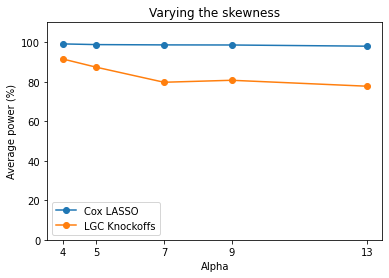

In [85]:
#Average power plot 

x_points = np.array(results.index)
y1_points = np.array(results["CoxLasso_Power(%)"])
y2_points = np.array(results["knockoff_hat_Power(%)"])
plt.plot(x_points, y1_points,marker = 'o', label="Cox LASSO")
plt.plot(x_points, y2_points,marker = 'o',label="LGC Knockoffs")
plt.ylim(0, 110)
plt.xticks(x_points)
plt.legend(loc="lower left")
plt.title("Varying the skewness")
plt.xlabel("Alpha")
plt.ylabel("Average power (%)")
plt.show()

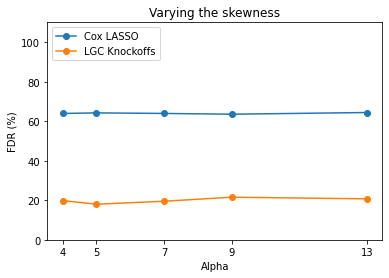

In [86]:
#FDR power plot 

x_points = np.array(results.index)
y1_points = np.array(results["CoxLasso_FDP(%)"])
y2_points = np.array(results["knockoff_hat_FDP(%)"])
plt.plot(x_points, y1_points,marker = 'o', label="Cox LASSO")
plt.plot(x_points, y2_points,marker = 'o',label="LGC Knockoffs")
plt.ylim(0, 110)
plt.xticks(x_points)
plt.legend(loc="upper left")
plt.title("Varying the skewness")
plt.xlabel("Alpha")
plt.ylabel("FDR (%)")
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/tmp/ipykernel_2611580/776550072.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


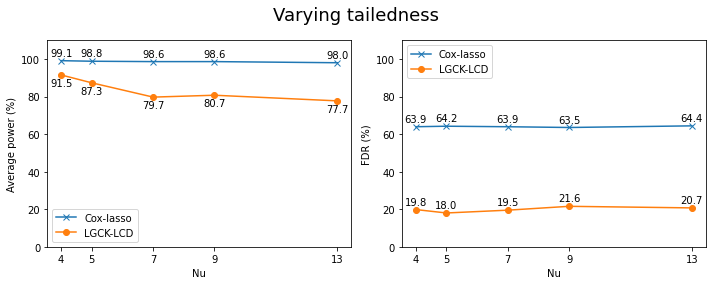

In [90]:
#Average power and FDR plots side-by-side

x_points = np.array(results.index)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Varying tailedness',fontsize=18)
fig.set_figwidth(10)
fig.set_figheight(4)

y1_points = np.around(np.array(results["CoxLasso_Power(%)"]),decimals=1)
y2_points = np.array(results["knockoff_hat_Power(%)"])

for i, j in zip(x_points,y1_points):
    ax1.text(i, j+2.5, "{:.1f}".format(j), ha="center")
for i, j in zip(x_points,y2_points):
    ax1.text(i, j-6, "{:.1f}".format(j), ha="center")
    
    
ax1.plot(x_points, y1_points, marker = 'x', label="Cox-lasso")
ax1.plot(x_points, y2_points, marker = 'o', label="LGCK-LCD")
ax1.set_ylim(0, 110)
ax1.set_xticks(x_points)
ax1.legend(loc="lower left")
ax1.set_xlabel("Nu")
ax1.set_ylabel("Average power (%)")

y1_points = np.array(results["CoxLasso_FDP(%)"])
y2_points = np.array(results["knockoff_hat_FDP(%)"])
for i, j in zip(x_points,y1_points):
    ax2.text(i, j+2.5, "{:.1f}".format(j), ha="center")
for i, j in zip(x_points,y2_points):
    ax2.text(i, j+2.5, "{:.1f}".format(j), ha="center")
    
ax2.plot(x_points, y1_points, marker = 'x', label="Cox-lasso")
ax2.plot(x_points, y2_points, marker = 'o',label="LGCK-LCD")
ax2.set_ylim(0, 110)
ax2.set_xticks(x_points)
ax2.legend(loc="upper left")
ax2.set_xlabel("Nu")
ax2.set_ylabel("FDR (%)")

fig.tight_layout()

fig.savefig("t2_n300_p300_Varying_nu_2sep22.eps", format="eps", dpi=1200)
fig.savefig("t2_n300_p300_Varying_nu_2sep22.jpg", format="jpg", dpi=300)
fig.show()

In [88]:
#df_simulations_results.to_csv('results_varying_nu_29ago22.csv')

In [89]:
nsim

50

ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 22 warnings (use warnings() to see them)
R[write to console]: 



ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 27 warnings (use warnings() to see them)
R[write to console]: 



ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 27 warnings (use warnings() to see them)
R[write to console]: 



ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 22 warnings (use warnings() to see them)
R[write to console]: 



ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 23 warnings (use warnings() to see them)
R[write to console]: 



ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 22 warnings (use warnings() to see them)
R[write to console]: 



ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 25 warnings (use warnings() to see them)
R[write to console]: 



ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 22 warnings (use warnings() to see them)
R[write to console]: 



ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 18 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 22 warnings (use warnings() to see them)
R[write to console]: 



ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 22 warnings (use warnings() to see them)
R[write to console]: 



ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 16 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 22 warnings (use warnings() to see them)
R[write to console]: 



ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 23 warnings (use warnings() to see them)
R[write to console]: 



ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 22 warnings (use warnings() to see them)
R[write to console]: 



ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 23 warnings (use warnings() to see them)
R[write to console]: 



ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 27 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 26 warnings (use warnings() to see them)
R[write to console]: 



ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 22 warnings (use warnings() to see them)
R[write to console]: 



ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 15 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 14 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 22 warnings (use warnings() to see them)
R[write to console]: 



ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 29 warnings (use warnings() to see them)
R[write to console]: 



ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 25 warnings (use warnings() to see them)
R[write to console]: 



ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 26 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 26 warnings (use warnings() to see them)
R[write to console]: 



ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 10 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 29 warnings (use warnings() to see them)
R[write to console]: 



ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 32 warnings (use warnings() to see them)
R[write to console]: 



ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 21 iterations with status: optimal.
ADMM terminated after 25 iterations with status: optimal.
ADMM terminated after 14 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminated after 13 iterations with status: optimal.
ADMM terminated after 11 iterations with status: optimal.
ADMM terminated after 23 iterations with status: optimal.
ADMM terminated after 12 iterations with status: optimal.
ADMM terminated after 24 iterations with status: optimal.
ADMM terminated after 22 iterations with status: optimal.
ADMM terminate

R[write to console]: There were 27 warnings (use warnings() to see them)
R[write to console]: 

